# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("final_customers_df.csv")

# Utils

In [4]:
def barplot(df, variable, size=7):
    plt.figure(figsize=(size, size))
    sns.countplot(y=variable, data=df)
    plt.title(variable)
    plt.show()

def uni_ana_qual(df, variable, size=7):
    print('Unique values :\n' , df[variable].unique())
    barplot(df, variable, size)

def uni_ana_quant(df, variable):  
    fig, axes = plt.subplots(1, 3, figsize=(25, 3))
    fig.suptitle(variable)

    sns.histplot(ax=axes[0], x=variable, data=df, kde=True)
    sns.boxplot(ax=axes[1], x=variable, data=df)
    sns.boxplot(ax=axes[2], x=variable, data=df, showfliers = False)
    plt.xlabel(f"{variable} without outliers")


# RFM variables

In [5]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'customer_state', 'nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered', 'most_frequent_payment_type',
       'mean_payment_installments', 'mean_review_score',
       'most_frequent_product_category', 'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency'],
      dtype='object')

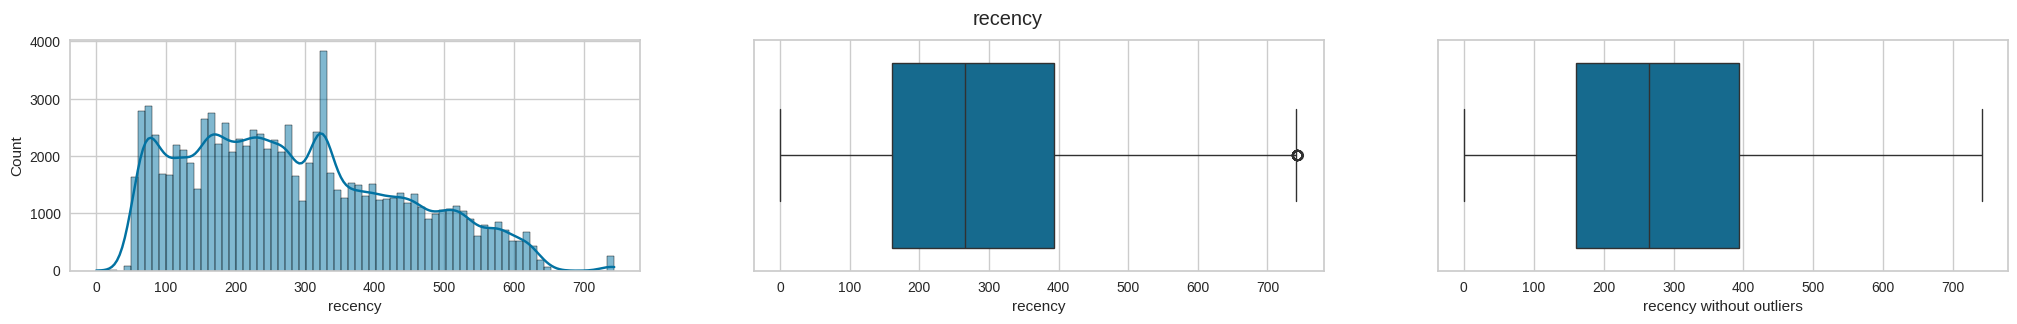

In [6]:
uni_ana_quant(df, "recency")

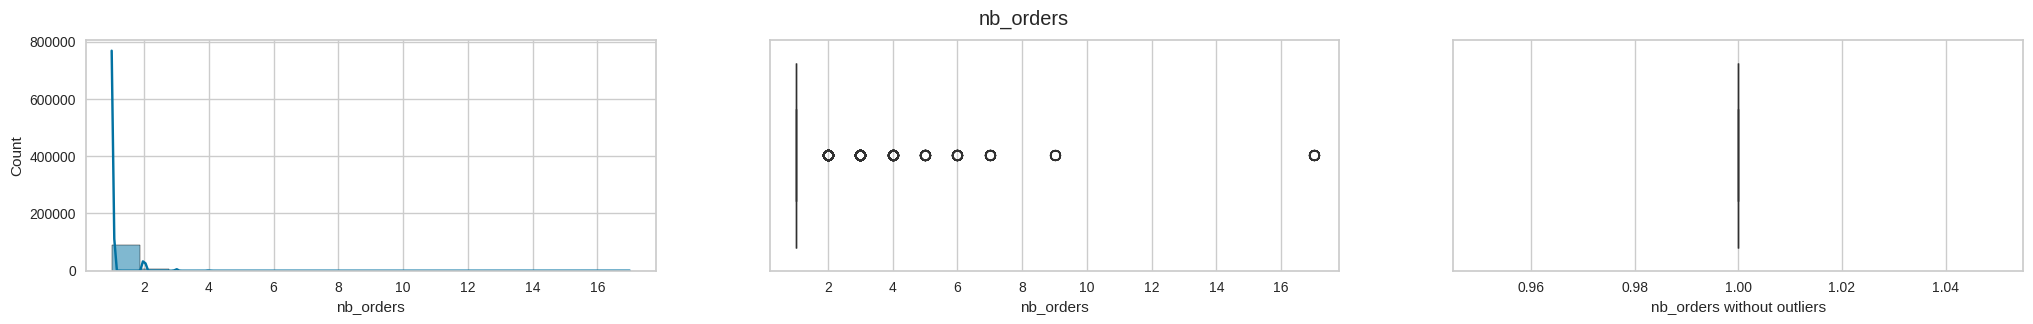

In [7]:
uni_ana_quant(df, "nb_orders")

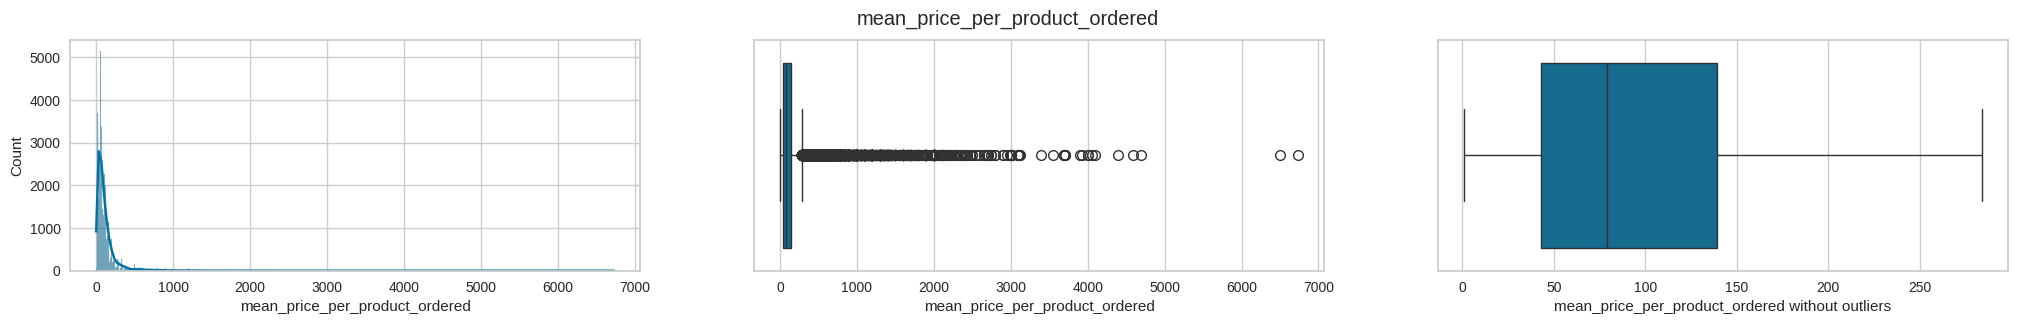

In [8]:
uni_ana_quant(df, "mean_price_per_product_ordered")

# Modelisation pipeline on RFM

## Test

In [9]:
result_df = pd.DataFrame(columns=[
    'model_name', 'fit_time (s)', 'best_params', 'mean_test_score'
])

In [10]:
X_train = df[["recency", "nb_orders", "mean_price_per_product_ordered"]]

scaler = StandardScaler()

kmeans = KMeans()
#dbscan = DBSCAN()

param_grid_kmeans = [
    {
        'clusterer': [KMeans()],
        'clusterer__n_clusters': np.arange(2, 8),
        'clusterer__init': ['k-means++', 'random'],
        'clusterer__n_init': [10]
    },

]

pipeline_kmeans = Pipeline([
    ('scaler', scaler), 
    ('clusterer', kmeans)
])

In [11]:
def process_cv(model_name, pipeline, param_grid, X_train):
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, refit=True)
    grid_search.fit(X_train)
    
    best_index = grid_search.best_index_
    results = grid_search.cv_results_

    mean_fit_time = results['mean_fit_time'][best_index]
    mean_test_score = results['mean_test_score'][best_index]

    new_row = [
        model_name,
        round(mean_fit_time, 2),
        grid_search.best_params_,
        round(mean_test_score, 2)
    ]

    result_df.loc[len(result_df)] = new_row

    return grid_search


In [12]:
grid_search_kmeans = process_cv("kmeans_RFM", pipeline_kmeans, param_grid_kmeans, X_train)

In [13]:
print(grid_search_kmeans.best_params_)
result_df

{'clusterer': KMeans(), 'clusterer__init': 'k-means++', 'clusterer__n_clusters': 7, 'clusterer__n_init': 10}


,model_name,fit_time (s),best_params,mean_test_score
0,kmeans_RFM,0.41,"{'clusterer': KMeans(), 'clusterer__init': 'k-...",-21574.67


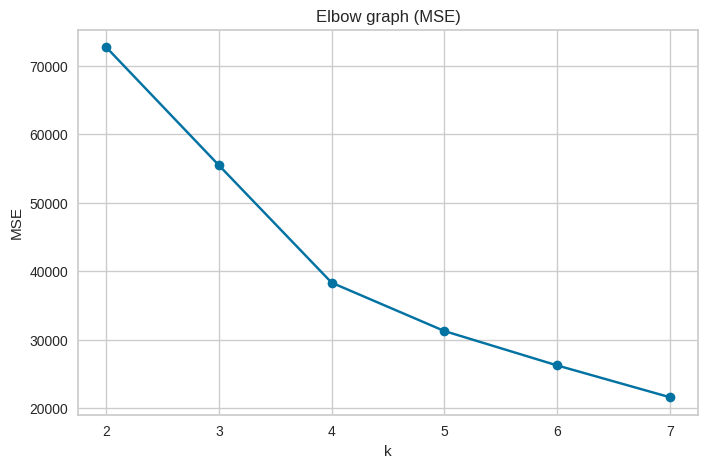

In [14]:
results = grid_search_kmeans.cv_results_

mean_errors = []
k_values = np.arange(2, 8)

for k in k_values:
    mask = (results['param_clusterer'].astype(str) == 'KMeans()') & (results['param_clusterer__n_clusters'] == k)
    
    if mask.any():
        best_error_for_k = np.min(-results['mean_test_score'][mask])
        mean_errors.append(best_error_for_k)
    else:
        mean_errors.append(np.nan)

plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_errors, marker='o')
plt.title('Elbow graph (MSE)')
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()


In [15]:
df["kmeans_RFM"] = grid_search_kmeans.predict(X_train)

Unique values :
 [4 6 3 1 0 2 5]


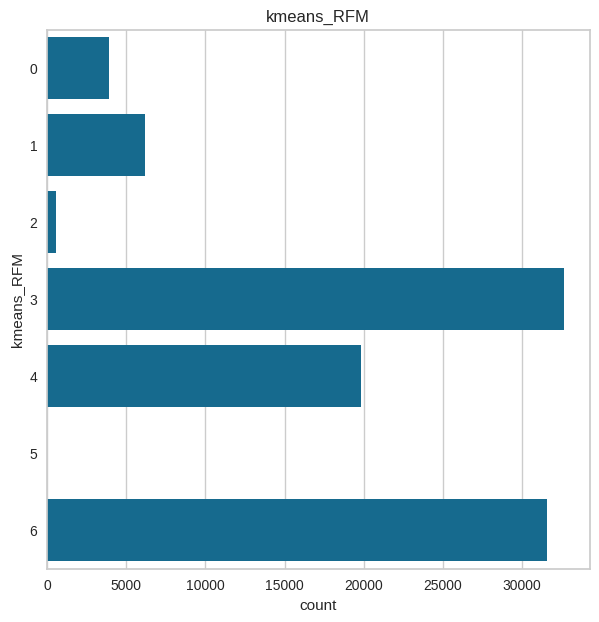

In [16]:
uni_ana_qual(df, "kmeans_RFM")

In [17]:
def anova(df, x, y):
    modalites = df[x].unique()
    groups = []
    for m in modalites:
        groups.append(df[df[x]==m][y])

    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
        
    plt.boxplot(groups, labels=modalites, showfliers=False, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.title(f'{x}, {y}')
    plt.figure(figsize=(13,13))
    plt.show()

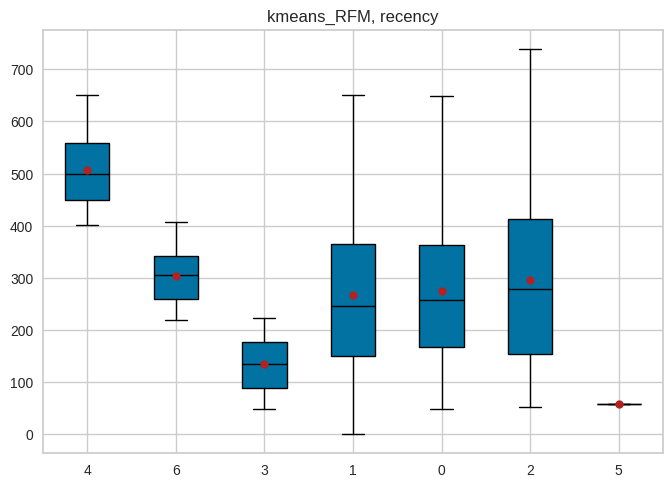

<Figure size 1300x1300 with 0 Axes>

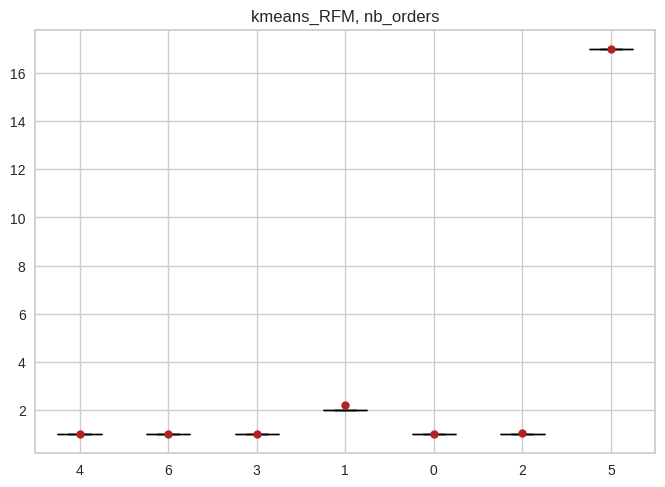

<Figure size 1300x1300 with 0 Axes>

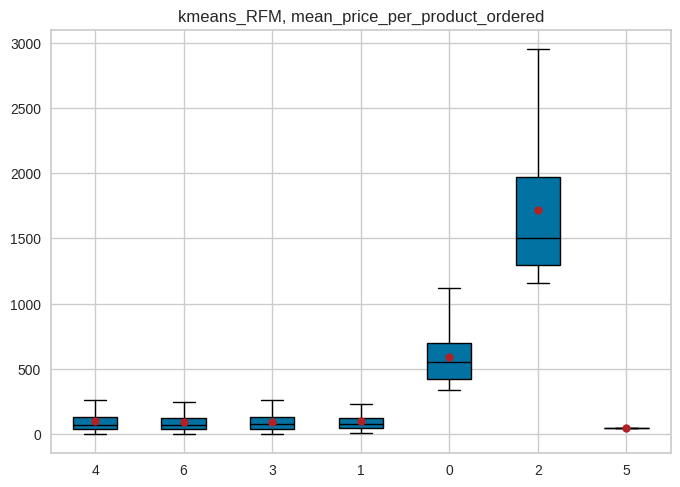

<Figure size 1300x1300 with 0 Axes>

In [18]:
anova(df, "kmeans_RFM", "recency")
anova(df, "kmeans_RFM", "nb_orders")
anova(df, "kmeans_RFM", "mean_price_per_product_ordered")

## Optimize number of clusters for RFM

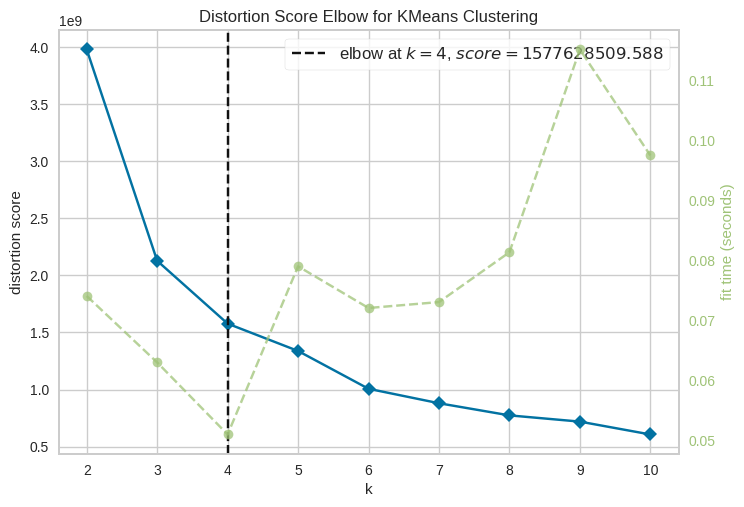

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(df[["recency", "nb_orders", "mean_price_per_product_ordered"]])
visualizer.poof()  

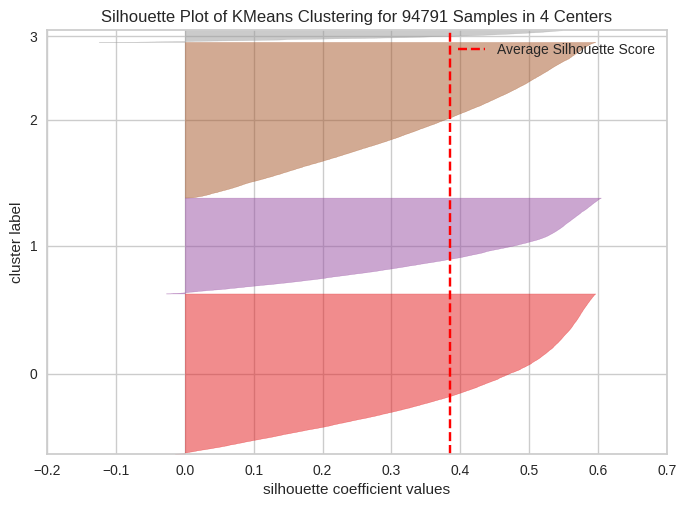

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94791 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df[["recency", "nb_orders", "mean_price_per_product_ordered"]])
visualizer.poof()

In [21]:
vars = ['customer_state', 'nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered', 'most_frequent_payment_type',
       'mean_payment_installments', 'mean_review_score',
       'most_frequent_product_category', 'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency']
numeric_features = ['nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered',
       'mean_payment_installments', 'mean_review_score',
       'most_frequent_product_category', 'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency']
categorical_features = ['customer_state', 'most_frequent_payment_type']

In [22]:
k=4

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml

In [24]:
X_train = df[["recency", "nb_orders", "mean_price_per_product_ordered"]]

scaler = StandardScaler()

kmeans_opti = KMeans()
#dbscan = DBSCAN()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardiser les variables numériques
        ('cat', OneHotEncoder(), categorical_features)  # Encoder les variables catégorielles
    ])

# Créer une pipeline avec le préprocesseur et un modèle de clustering (KMeans dans cet exemple)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', KMeans())
])
param_grid_kmeans_opti = [
    {
        'clusterer': [KMeans()],
        'clusterer__n_clusters': [k],
        'clusterer__init': ['k-means++', 'random'],
        'clusterer__n_init': [10]
    },
]

pipeline_kmeans_opti = Pipeline([
    ('preprocessor', preprocessor), 
    ('clusterer', kmeans)
])

In [25]:
def analyze(name, pipeline, param_grid, numeric_features, categorical_features, k):
    X_train = df[numeric_features+categorical_features]
    grid_search = process_cv(name, pipeline, param_grid, X_train)

    df[name] = grid_search.predict(X_train)
    uni_ana_qual(df, name)

    for variable in numeric_features:
        if variable in numeric_features:
            anova(df, name, variable)

    print(categorical_features)
    # Boxplots des variables par cluster
    for variable in categorical_features:
        print(variable)
        plt.figure(figsize=(40, 15))
        sns.histplot(
            data=df,
            x=variable,
            hue="test_pipeline",
            multiple="dodge",
            shrink=0.7,
            palette="Set1",
        )
        plt.xticks(rotation=75, ha="right")
        plt.show()

    from yellowbrick.cluster import InterclusterDistance
    from sklearn.decomposition import PCA

    # Inter cluster distance map


    # Instantiate the clustering model and visualizer
    model = KMeans(k, random_state=42)
    best_pipeline = grid_search.best_estimator_
    best_kmeans = best_pipeline.named_steps['clusterer']
    visualizer = InterclusterDistance(best_kmeans)

    df_visu_inter = df[vars]
    scaler = StandardScaler()
    X_scaled = preprocessor.fit_transform(df[vars])
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    visualizer.fit(
    # StandardScaler().fit_transform(    )
    X_scaled
    )  # Fit the data to the visualizer
    visualizer.show()  # Finalize and render the figure

    print("PCA Components:\n", pca.components_)

In [26]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'customer_state', 'nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered', 'most_frequent_payment_type',
       'mean_payment_installments', 'mean_review_score',
       'most_frequent_product_category', 'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency', 'kmeans_RFM'],
      dtype='object')

In [27]:
vars = ['customer_state', 'nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered', 'most_frequent_payment_type',
       'mean_payment_installments', 'mean_review_score',
       'most_frequent_product_category', 'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency']
numeric_features = ['nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered',
       'mean_payment_installments', 'mean_review_score',
       'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency']
categorical_features = ['customer_state', 'most_frequent_payment_type', 'most_frequent_product_category']

In [28]:
numeric_features = ['nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered',
       'mean_payment_installments', 'mean_review_score',
       'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delivery_time',
       'recency']
categorical_features = ['most_frequent_payment_type', 'most_frequent_product_category']

In [29]:
numeric_features = ['nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered',
       'mean_payment_installments', 'mean_review_score',
       'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delivery_time',
       'recency']
categorical_features = []

In [30]:
result_df

,model_name,fit_time (s),best_params,mean_test_score
0,kmeans_RFM,0.41,"{'clusterer': KMeans(), 'clusterer__init': 'k-...",-21574.67


In [31]:
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Applique le preprocessor
X_processed = preprocessor.fit_transform(df[numeric_features + categorical_features])

# Convertit en matrice dense si nécessaire
if hasattr(X_processed, 'toarray'):  # Vérifie si c'est une matrice sparse
    X_processed = X_processed.toarray()

# Initialise le modèle et le visualiseur
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11))

# Fit les données au visualiseur
visualizer.fit(X_processed)
visualizer.show()  # Affiche le graphe

ValueError: A given column is not a column of the dataframe

In [182]:
k=4
X_train = df[["recency", "nb_orders", "mean_price_per_product_ordered"]]

scaler = StandardScaler()

kmeans_opti = KMeans()
#dbscan = DBSCAN()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardiser les variables numériques
        ('cat', OneHotEncoder(), categorical_features)  # Encoder les variables catégorielles
    ])

# Créer une pipeline avec le préprocesseur et un modèle de clustering (KMeans dans cet exemple)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', KMeans())
])
param_grid_kmeans_opti = [
    {
        'clusterer': [KMeans()],
        'clusterer__n_clusters': [k],
        'clusterer__init': ['k-means++', 'random'],
        'clusterer__n_init': [10]
    },
    # {
    #     'clusterer': [DBSCAN()],
    #     'clusterer__eps': np.arange(0.1, 1.5, 0.2),
    #     'clusterer__min_samples': np.arange(3, 10),
    # }
]

pipeline_kmeans_opti = Pipeline([
    ('preprocessor', preprocessor), 
    ('clusterer', kmeans)
])

In [154]:
k=7

# Kmeans : all variables, k=6

Unique values :
 [1 5 3 0 2 4]


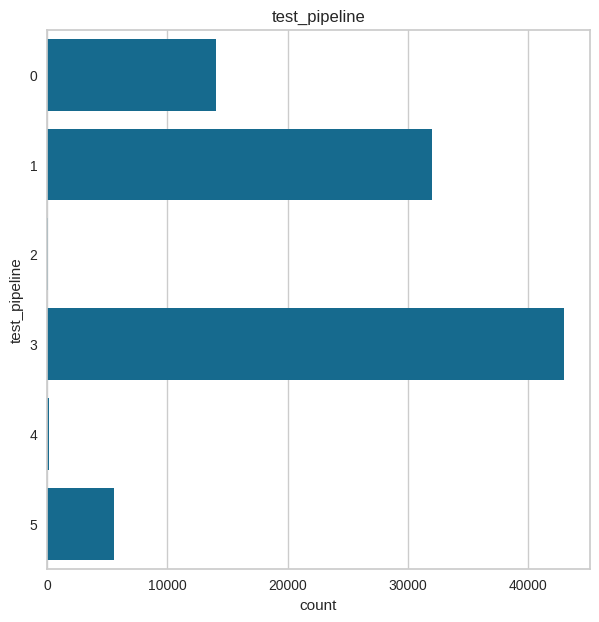

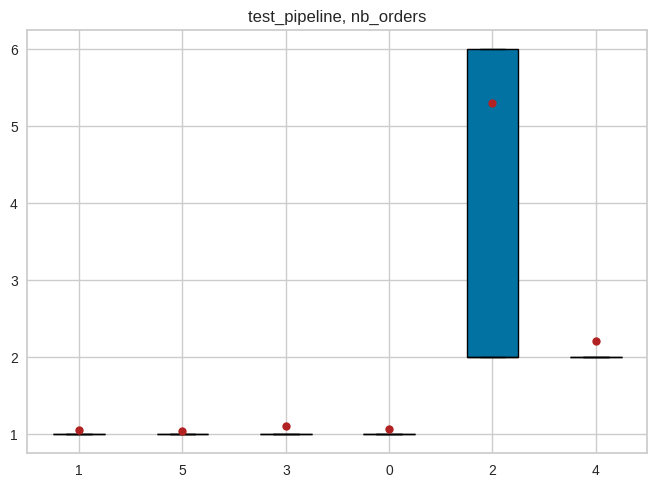

<Figure size 1300x1300 with 0 Axes>

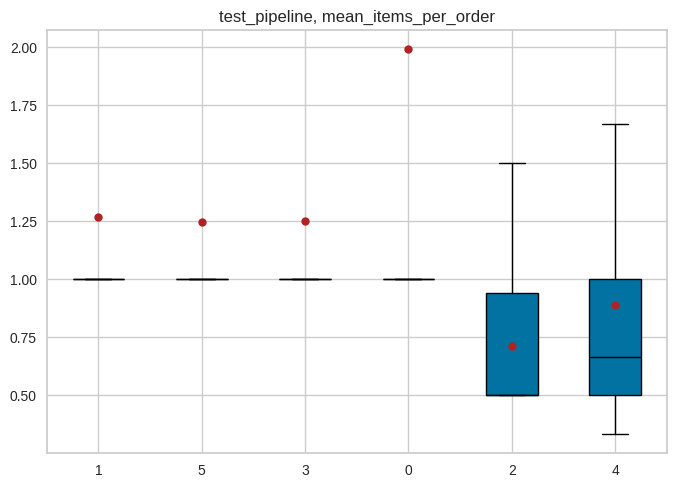

<Figure size 1300x1300 with 0 Axes>

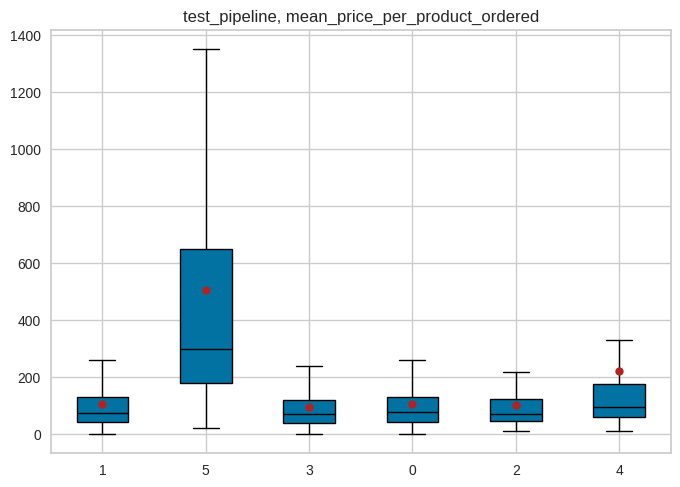

<Figure size 1300x1300 with 0 Axes>

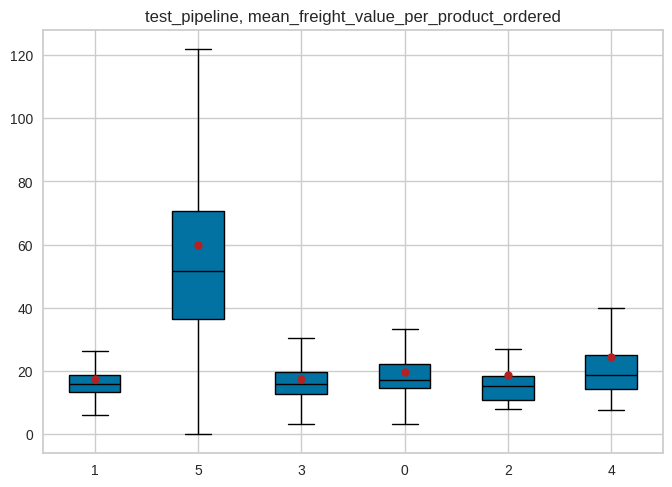

<Figure size 1300x1300 with 0 Axes>

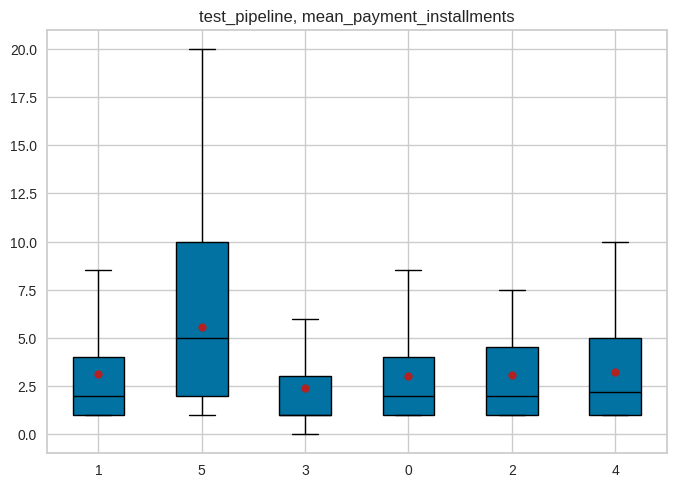

<Figure size 1300x1300 with 0 Axes>

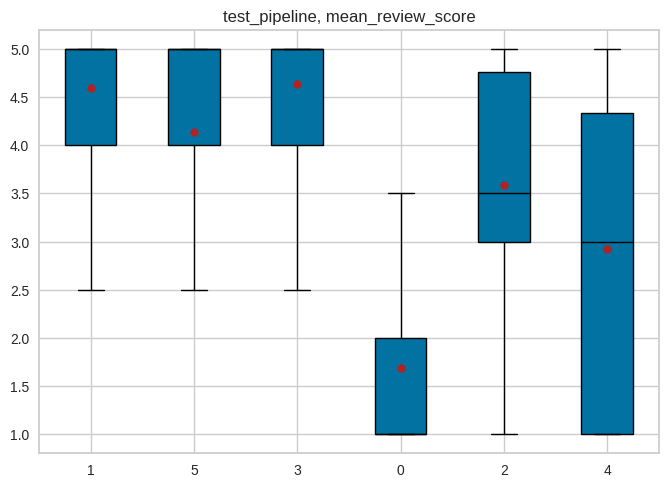

<Figure size 1300x1300 with 0 Axes>

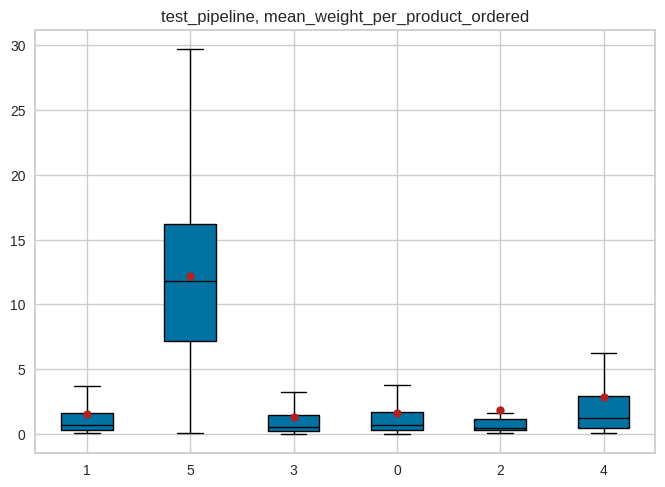

<Figure size 1300x1300 with 0 Axes>

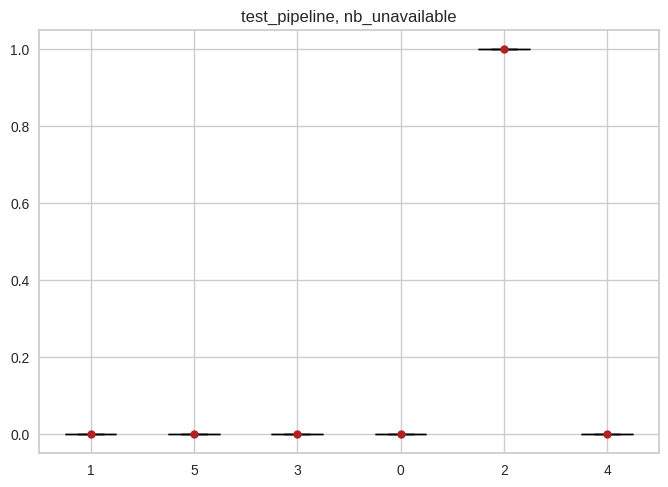

<Figure size 1300x1300 with 0 Axes>

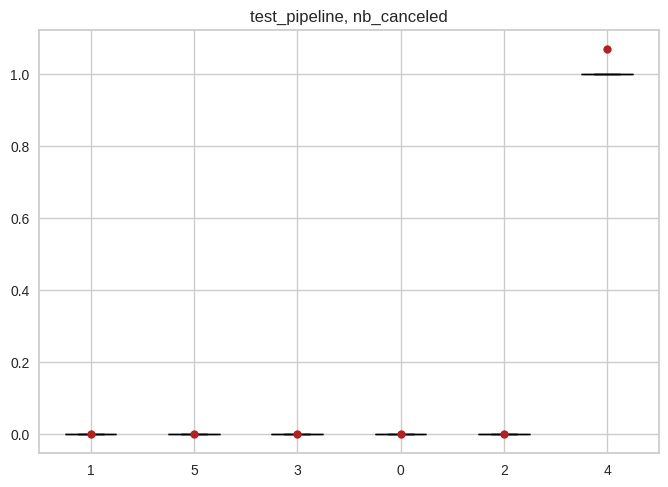

<Figure size 1300x1300 with 0 Axes>

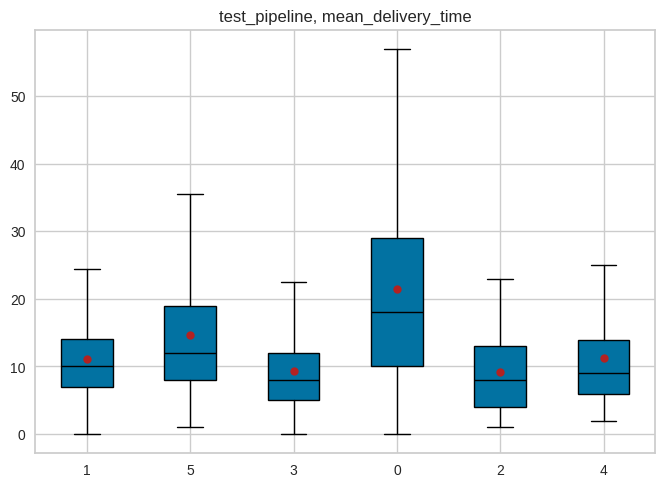

<Figure size 1300x1300 with 0 Axes>

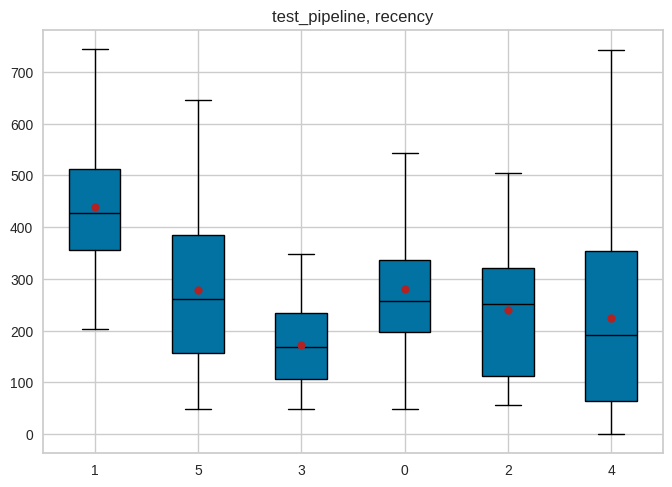

<Figure size 1300x1300 with 0 Axes>

[]


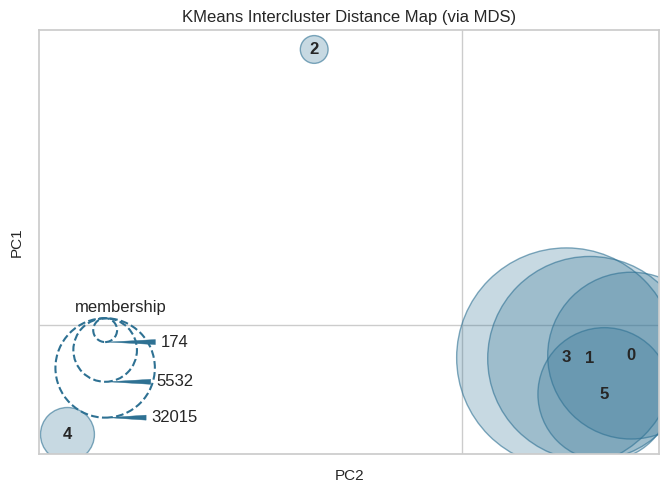

PCA Components:
 [[-0.02047541 -0.00614741  0.47436076  0.56641848  0.33846163 -0.10836385
   0.52671586 -0.00989799  0.02414515  0.22002485  0.02957115]
 [ 0.69574539  0.0091774   0.03499226  0.01178657  0.06174173  0.06802646
   0.01767887  0.63942052  0.24797956 -0.1240141  -0.14144469]]


In [179]:
analyze("test_pipeline", pipeline_kmeans_opti, param_grid_kmeans_opti, numeric_features, categorical_features, k)

# Kmeans : RFM + accurate variables, k=6

Unique values :
 [1 0 4 2 3]


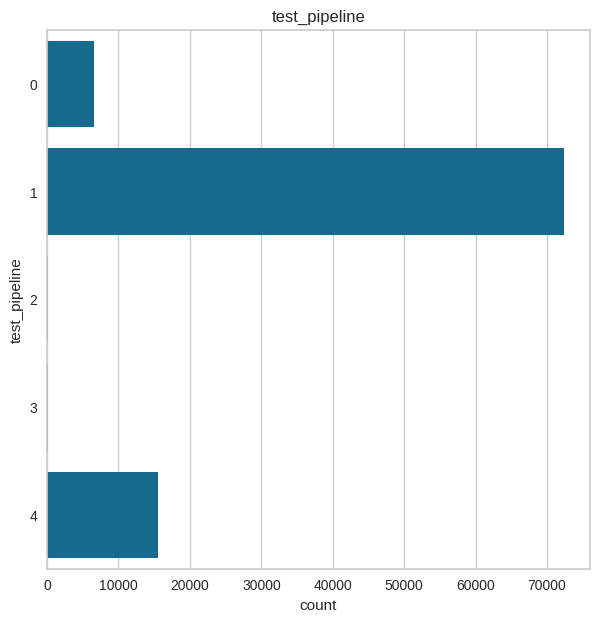

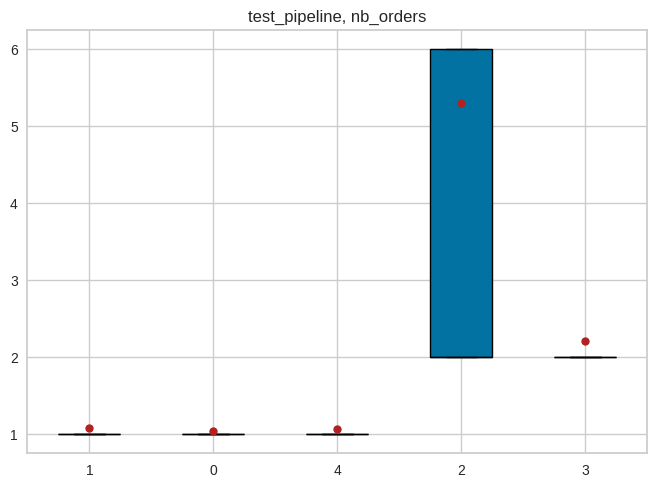

<Figure size 1300x1300 with 0 Axes>

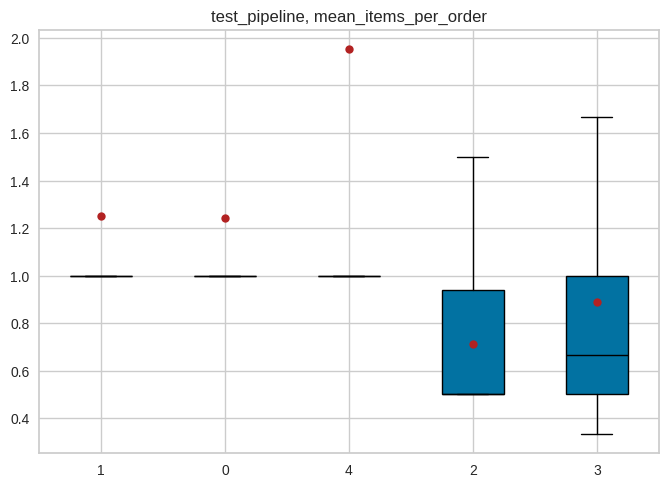

<Figure size 1300x1300 with 0 Axes>

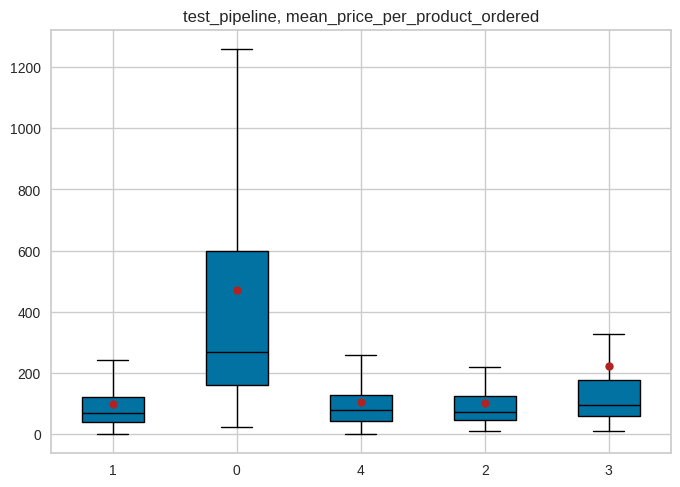

<Figure size 1300x1300 with 0 Axes>

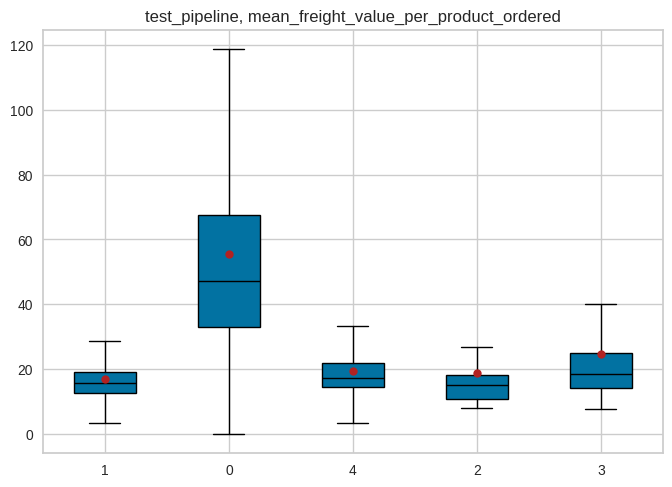

<Figure size 1300x1300 with 0 Axes>

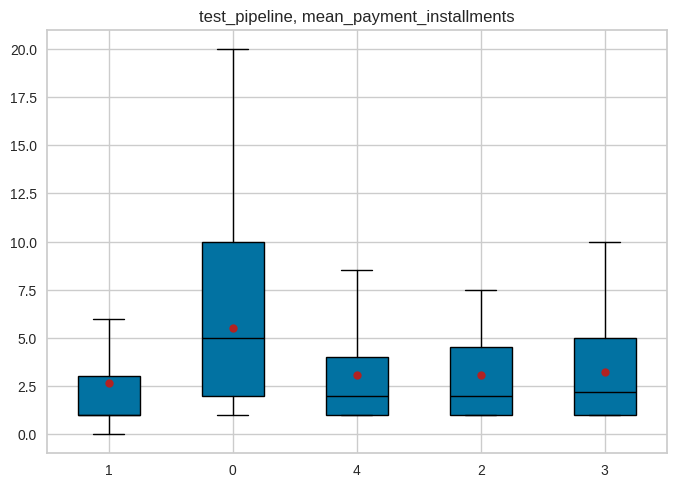

<Figure size 1300x1300 with 0 Axes>

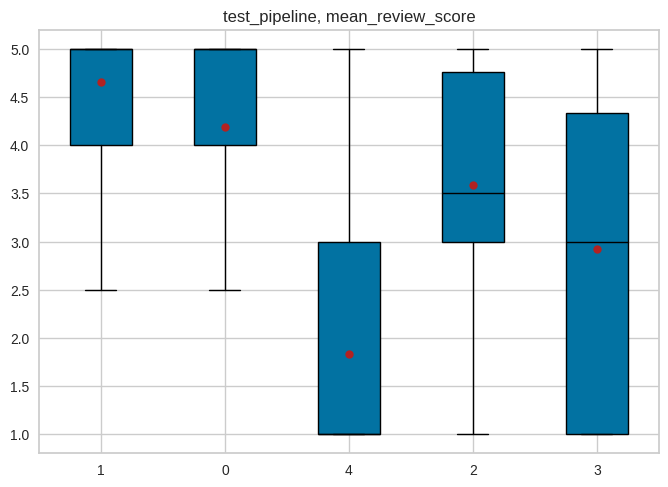

<Figure size 1300x1300 with 0 Axes>

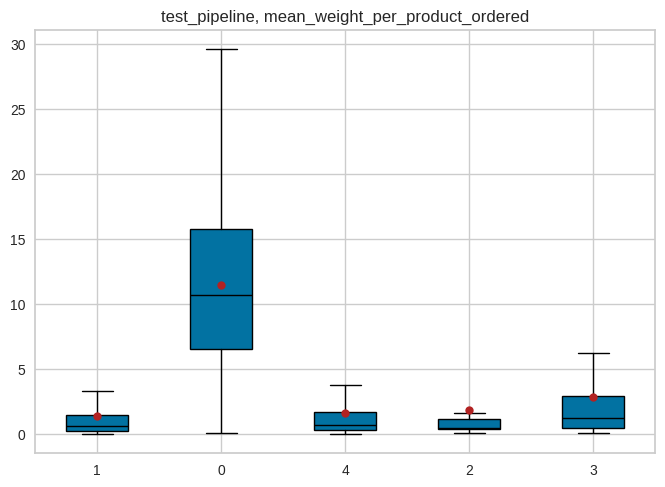

<Figure size 1300x1300 with 0 Axes>

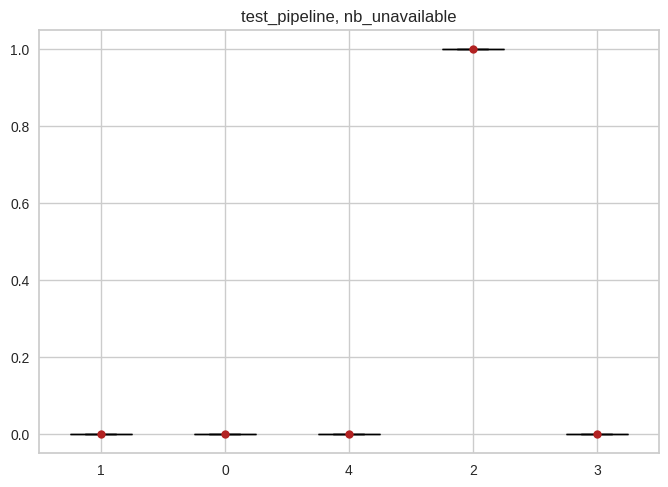

<Figure size 1300x1300 with 0 Axes>

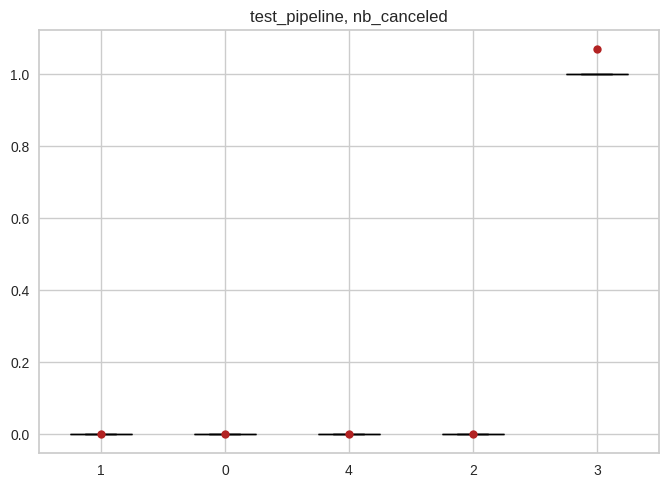

<Figure size 1300x1300 with 0 Axes>

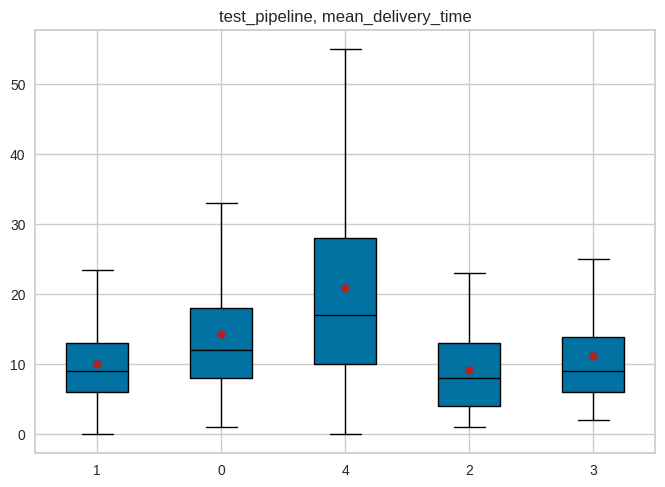

<Figure size 1300x1300 with 0 Axes>

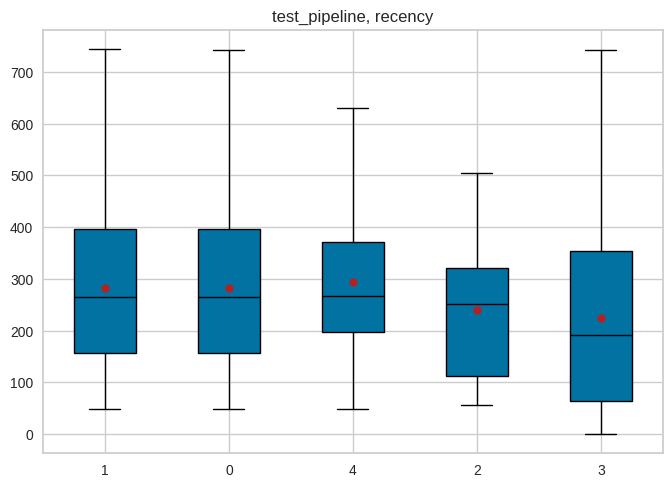

<Figure size 1300x1300 with 0 Axes>

['most_frequent_payment_type', 'most_frequent_product_category']
most_frequent_payment_type


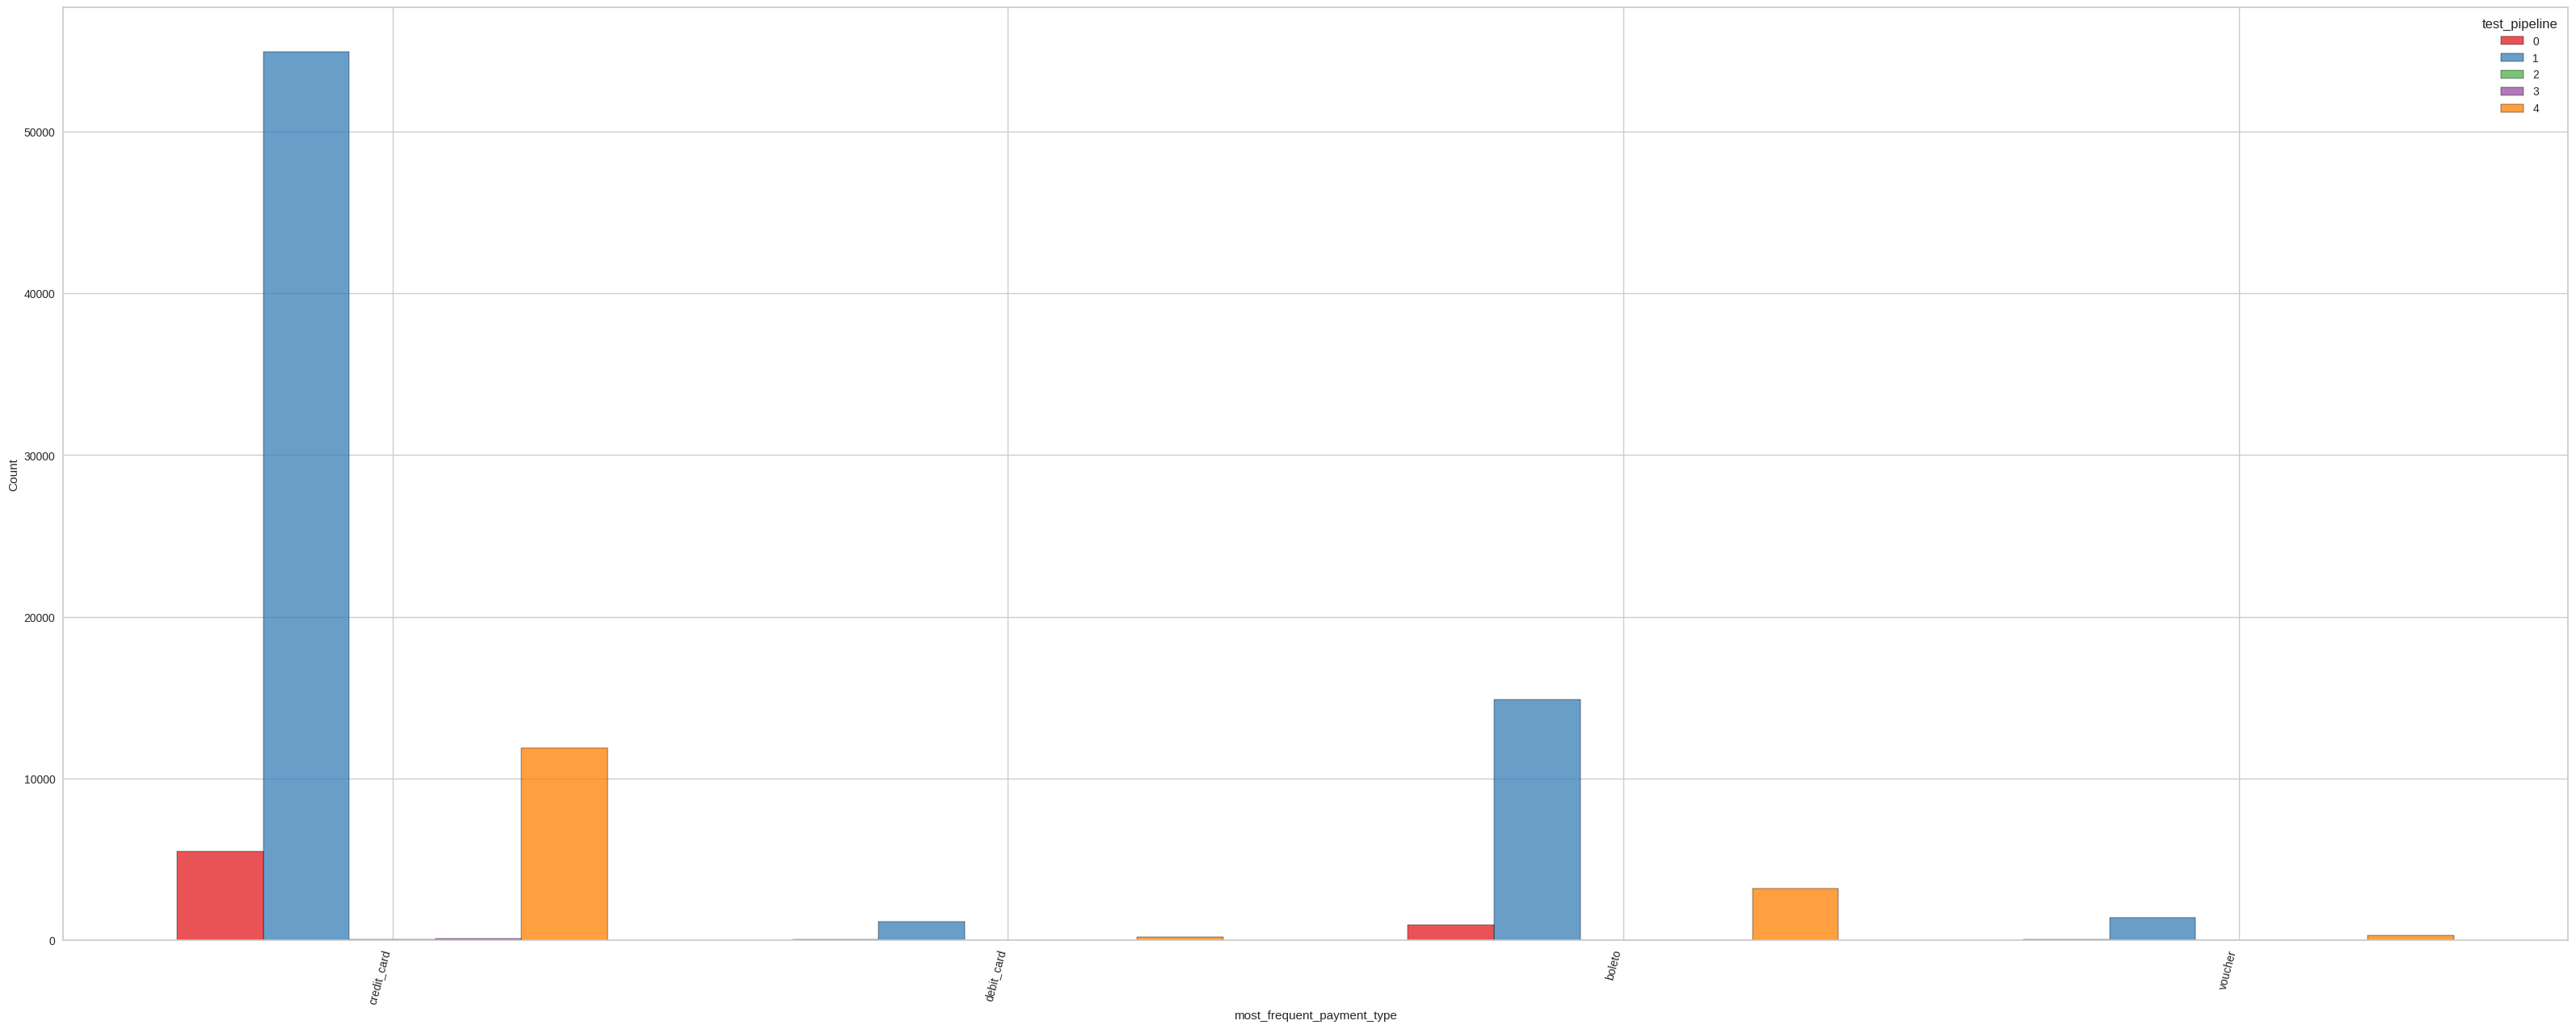

most_frequent_product_category


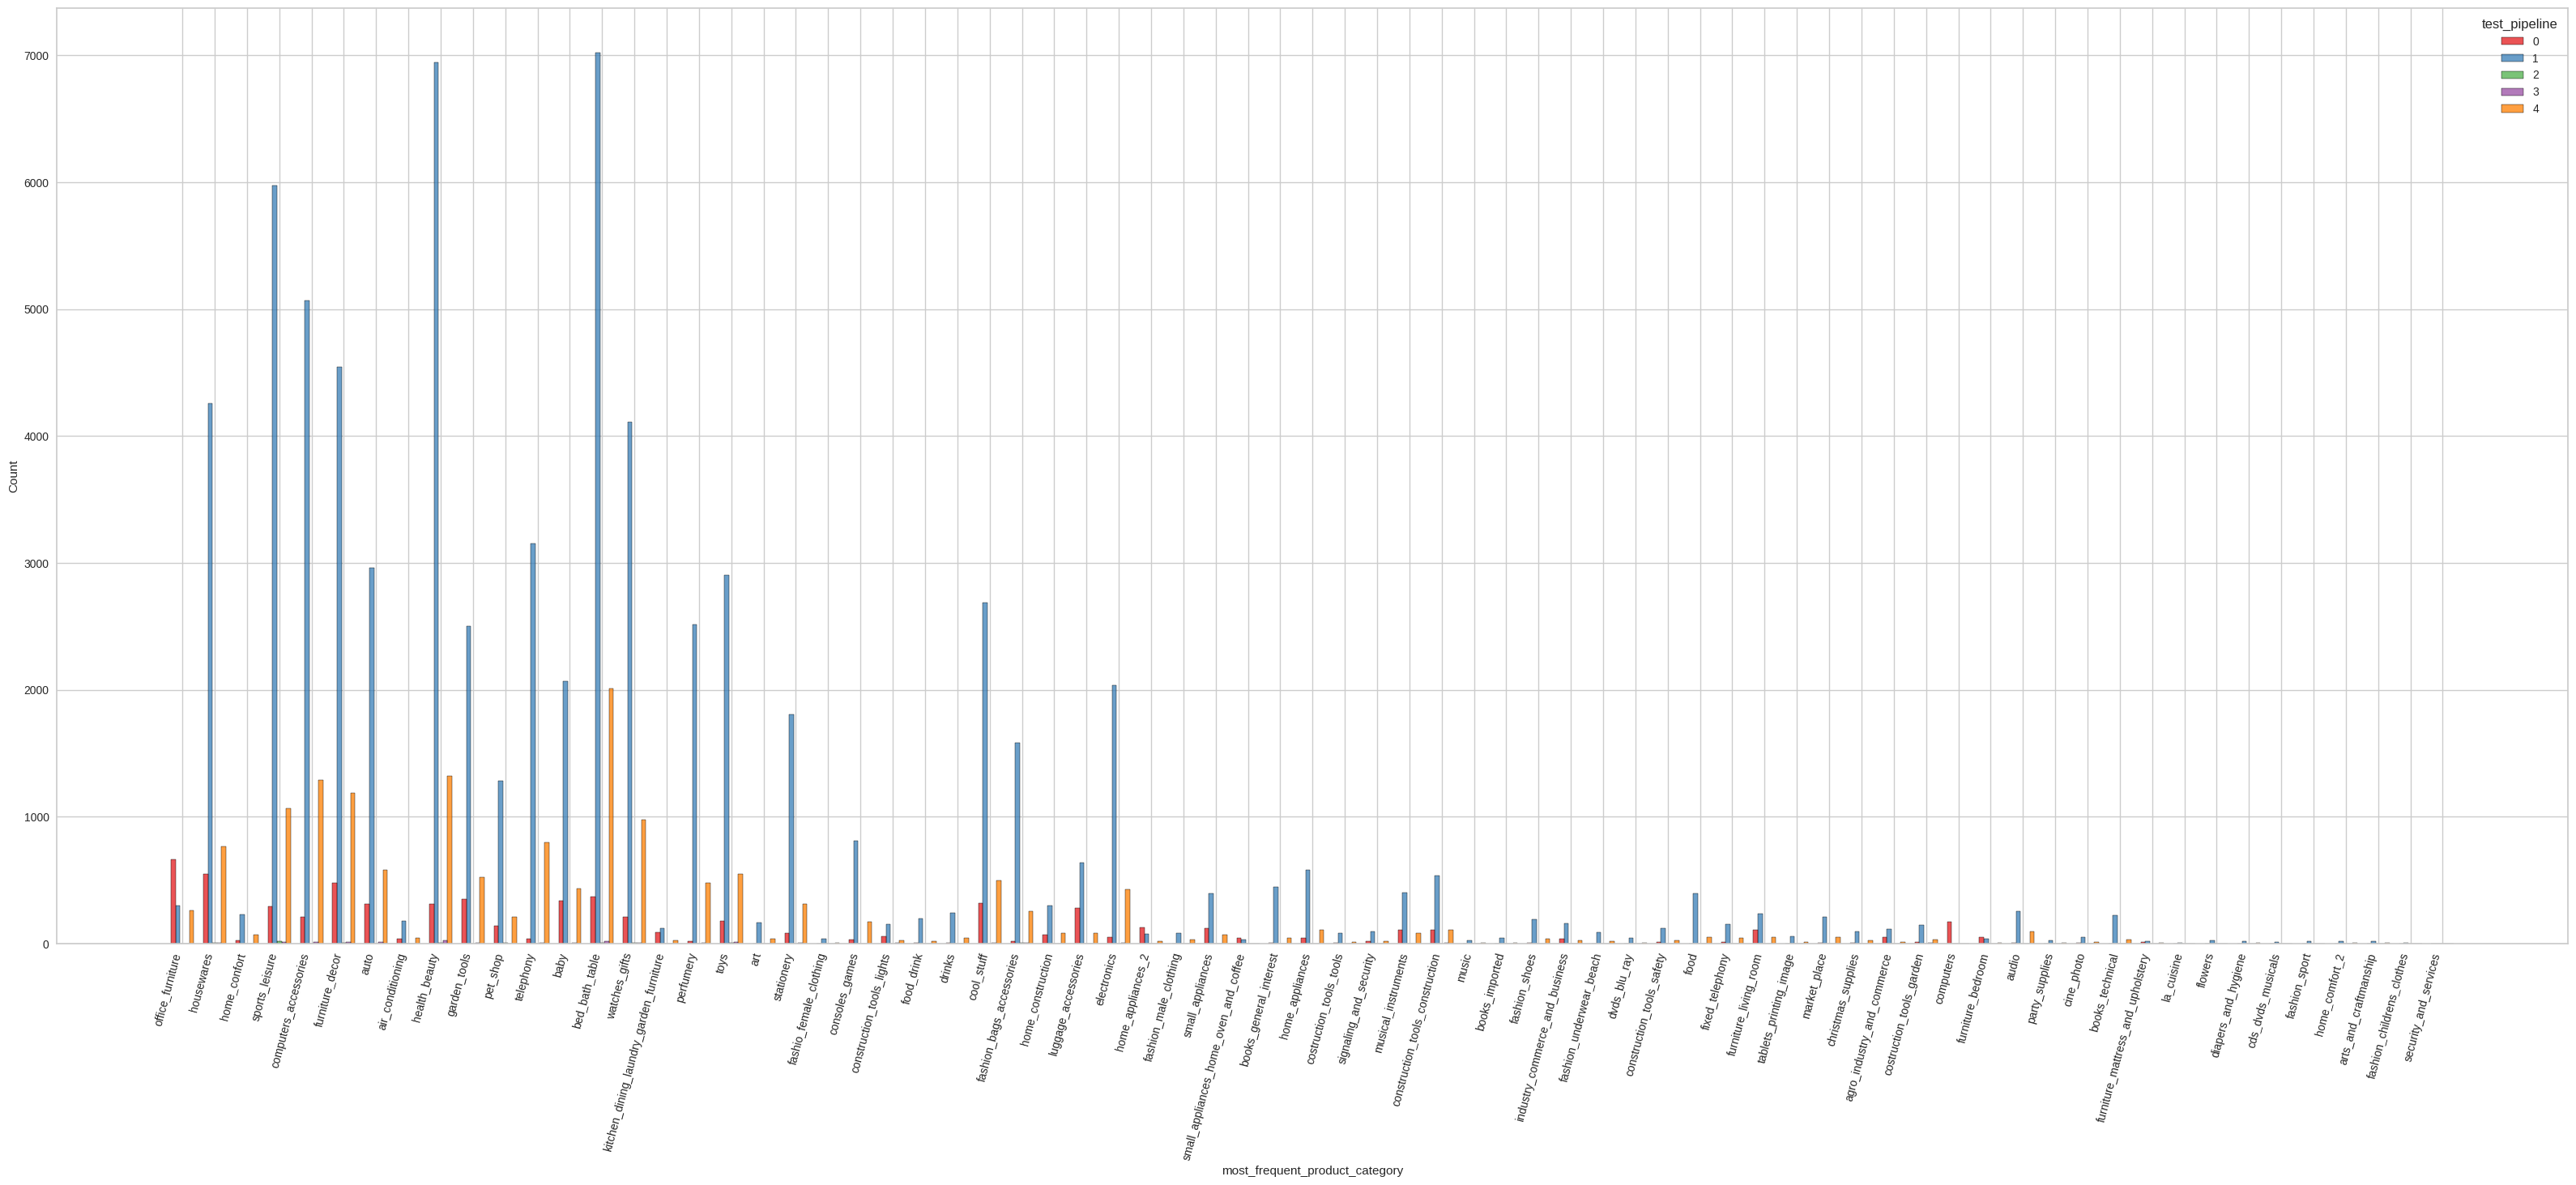

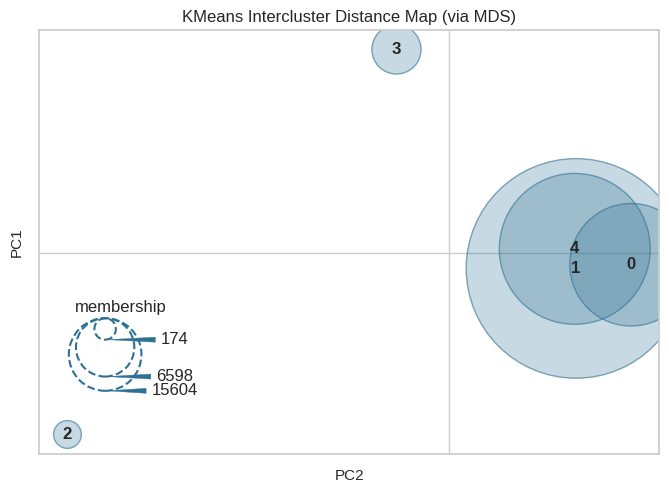

PCA Components:
 [[-2.01417407e-02 -6.16922955e-03  4.73275201e-01  5.63303980e-01
   3.45679053e-01 -1.06844005e-01  5.24544107e-01 -9.58750469e-03
   2.39388337e-02  2.16701497e-01  2.89483091e-02 -3.39246863e-02
   4.12091656e-02 -3.21894580e-03 -4.06553350e-03  9.98654380e-04
   5.19817677e-04 -2.55459999e-04 -8.26390631e-05 -3.72509241e-04
   2.60267149e-03  4.10805058e-03 -1.00501728e-04 -1.29119006e-03
  -2.07638333e-04 -7.80305969e-04 -3.62843267e-05 -8.92645935e-05
  -9.23678042e-05  3.94146084e-03 -1.01572143e-02 -1.44876790e-03
   1.43449525e-03  5.96496617e-04  1.10712643e-04  5.54486150e-03
   2.86317607e-05 -3.95879786e-05 -8.67918018e-05 -1.05931554e-03
  -1.22799745e-04 -7.88568212e-03 -1.15117277e-04 -5.63835001e-03
  -2.11357291e-05 -2.24044409e-04 -1.69572404e-04 -5.93087196e-05
  -3.37952111e-04 -2.33022299e-04 -9.72188184e-05 -1.70398637e-03
  -6.48532318e-04  8.58866177e-04  2.84422266e-03  2.91690950e-03
   2.80333280e-04  4.45112524e-03 -6.76516225e-03 -9.615909

In [174]:
analyze("test_pipeline", pipeline_kmeans_opti, param_grid_kmeans_opti, numeric_features, categorical_features, k)

# Kmeans : RFM + accurate variables, k=3

Unique values :
 [0 2 1]


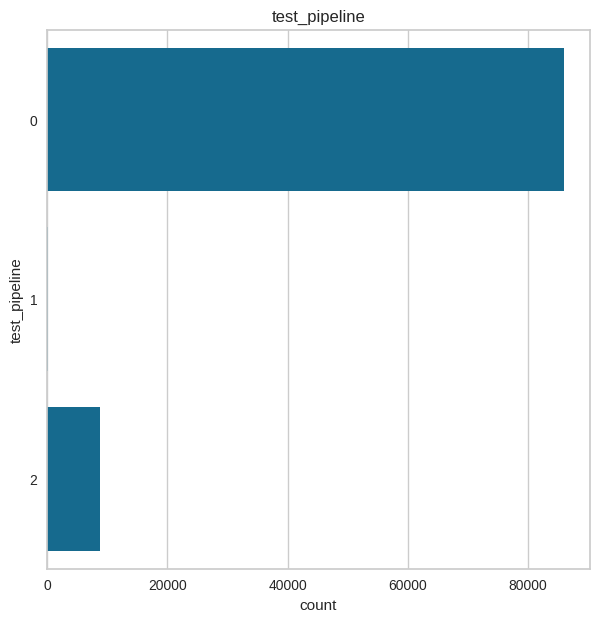

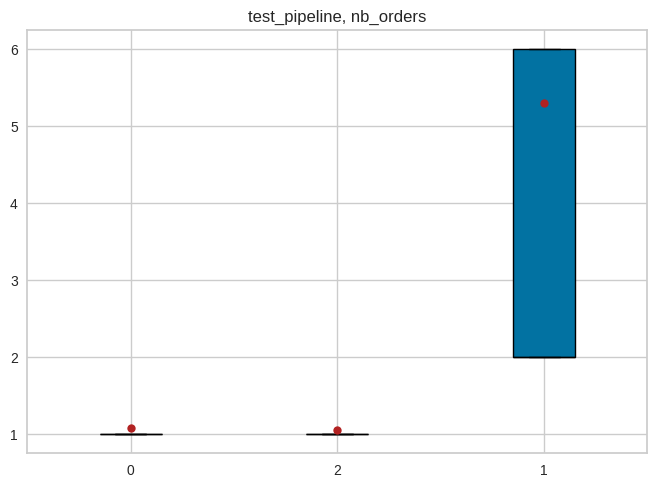

<Figure size 1300x1300 with 0 Axes>

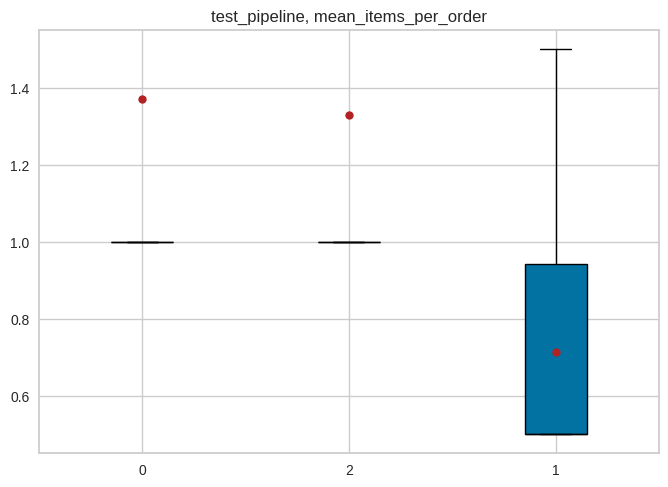

<Figure size 1300x1300 with 0 Axes>

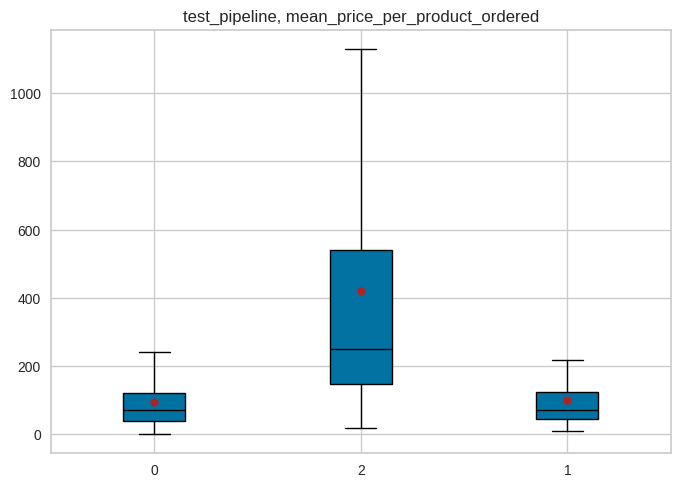

<Figure size 1300x1300 with 0 Axes>

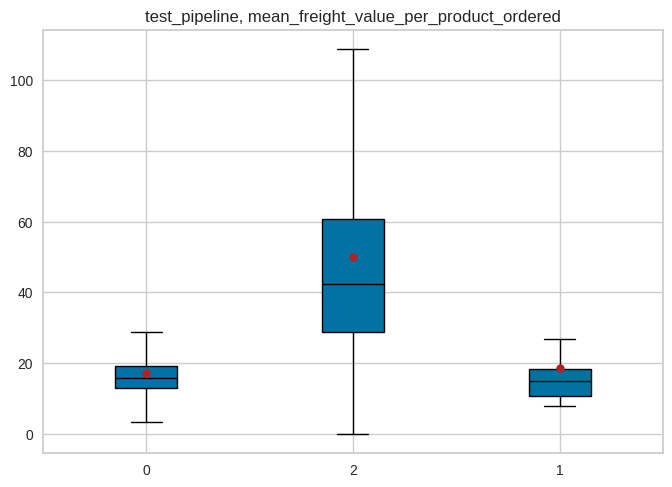

<Figure size 1300x1300 with 0 Axes>

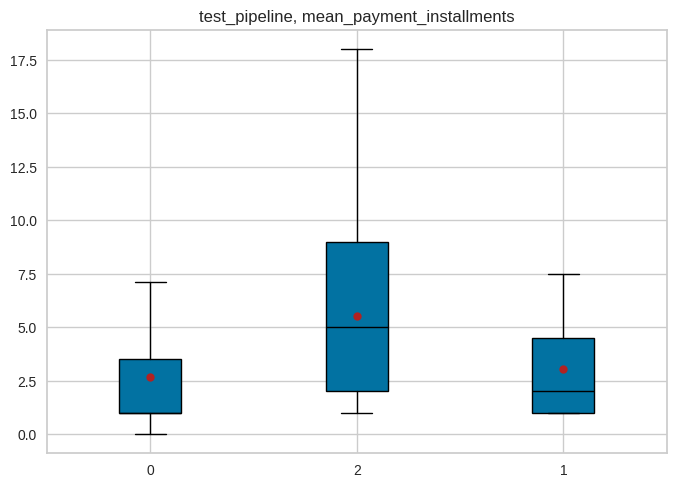

<Figure size 1300x1300 with 0 Axes>

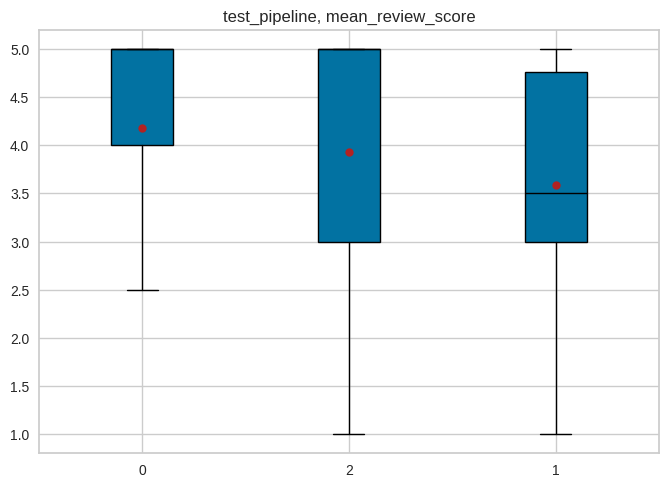

<Figure size 1300x1300 with 0 Axes>

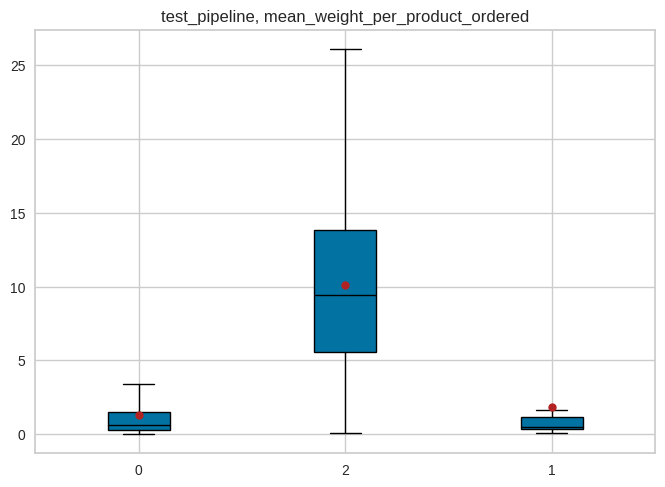

<Figure size 1300x1300 with 0 Axes>

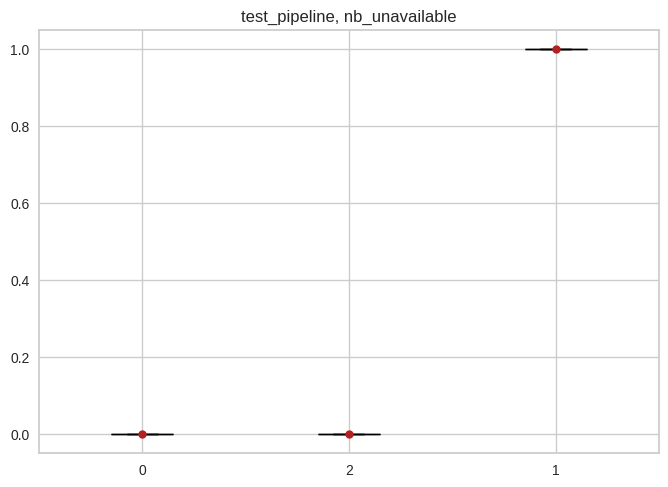

<Figure size 1300x1300 with 0 Axes>

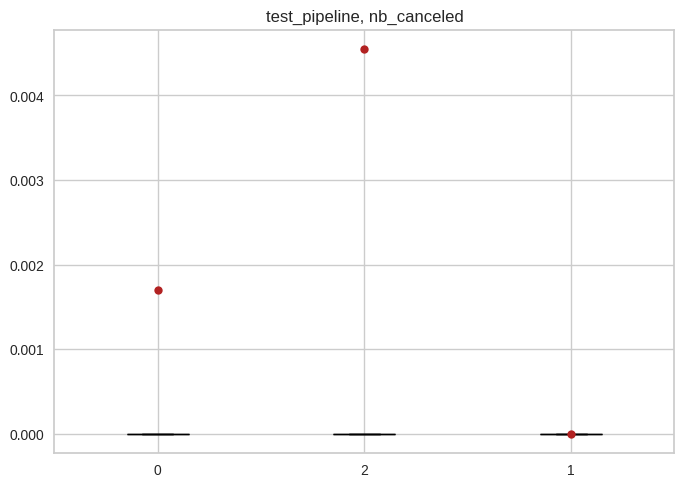

<Figure size 1300x1300 with 0 Axes>

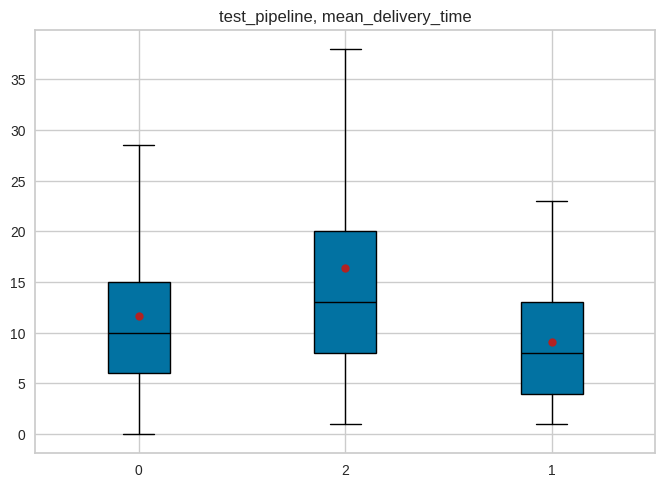

<Figure size 1300x1300 with 0 Axes>

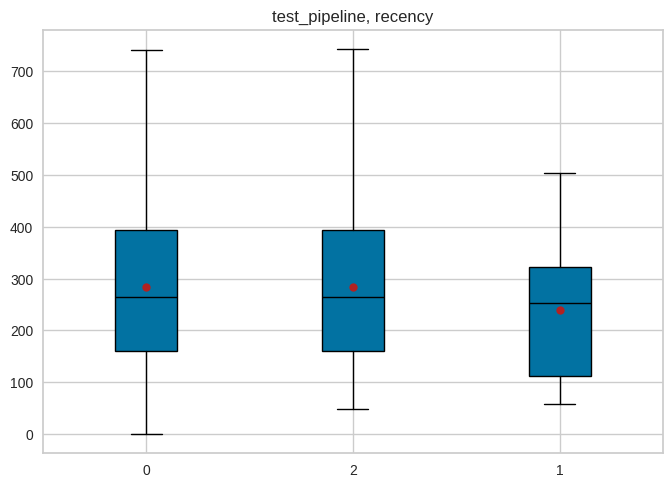

<Figure size 1300x1300 with 0 Axes>

[]


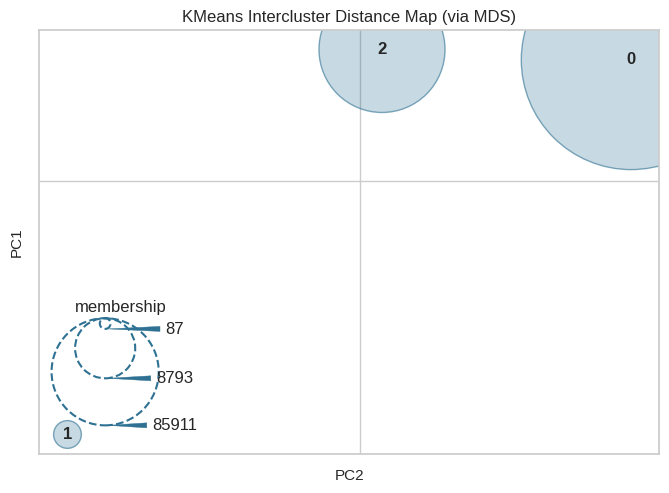

PCA Components:
 [[-0.02047541 -0.00614741  0.47436076  0.56641848  0.33846163 -0.10836385
   0.52671586 -0.00989799  0.02414515  0.22002485  0.02957115]
 [ 0.69574539  0.0091774   0.03499226  0.01178657  0.06174173  0.06802646
   0.01767887  0.63942052  0.24797956 -0.1240141  -0.14144469]]


In [181]:
analyze("test_pipeline", pipeline_kmeans_opti, param_grid_kmeans_opti, numeric_features, categorical_features, 3)

# Kmeans : RFM + accurate variables, k=4

Unique values :
 [1 0 3 2]


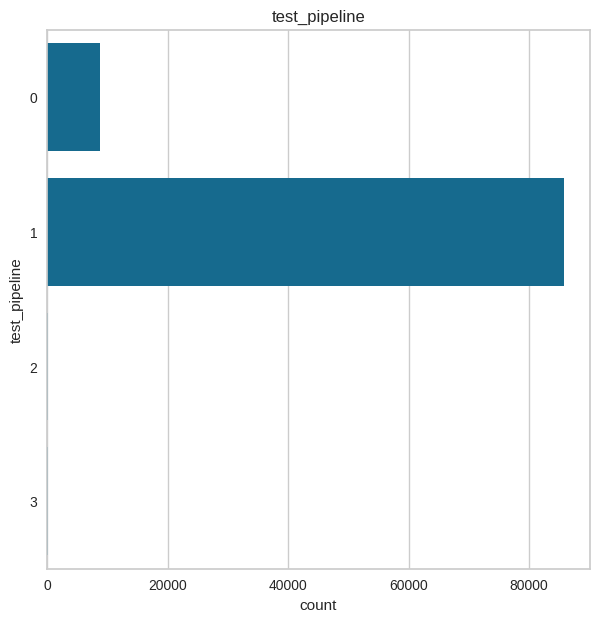

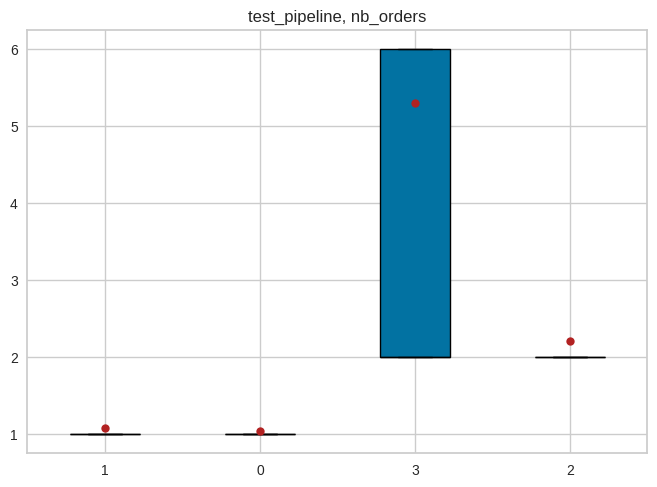

<Figure size 1300x1300 with 0 Axes>

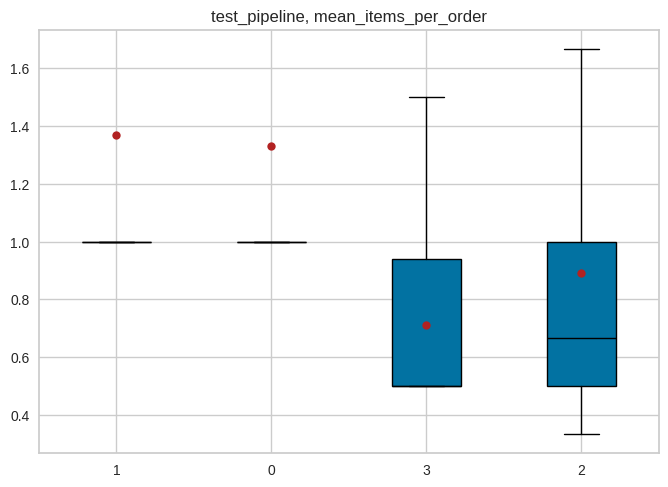

<Figure size 1300x1300 with 0 Axes>

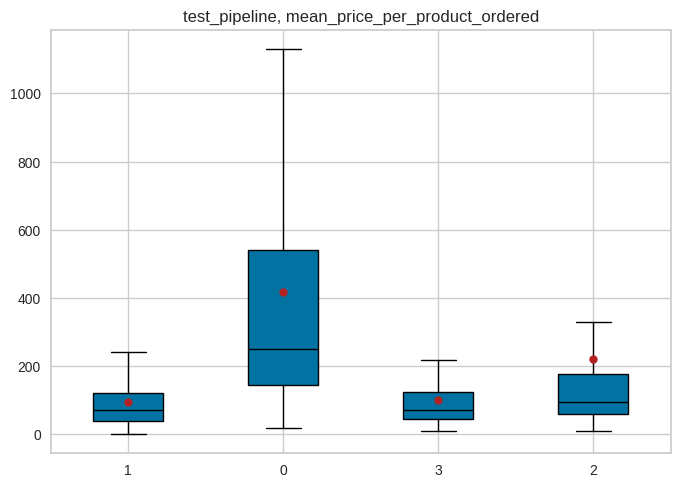

<Figure size 1300x1300 with 0 Axes>

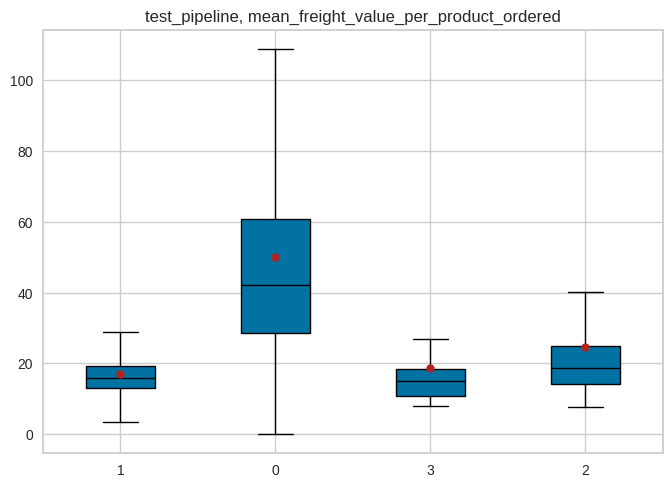

<Figure size 1300x1300 with 0 Axes>

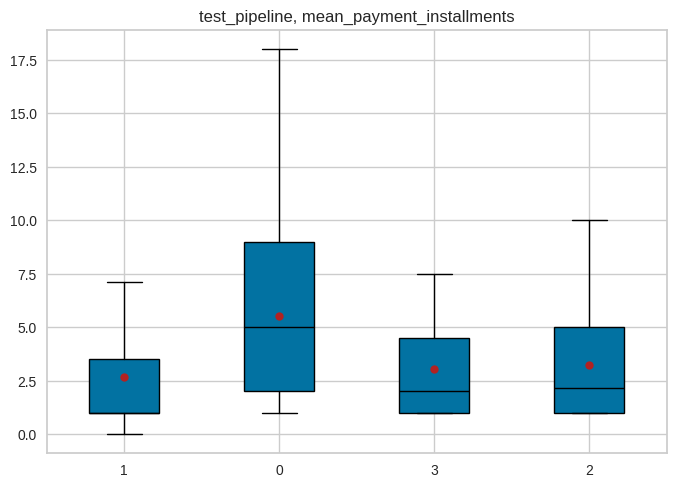

<Figure size 1300x1300 with 0 Axes>

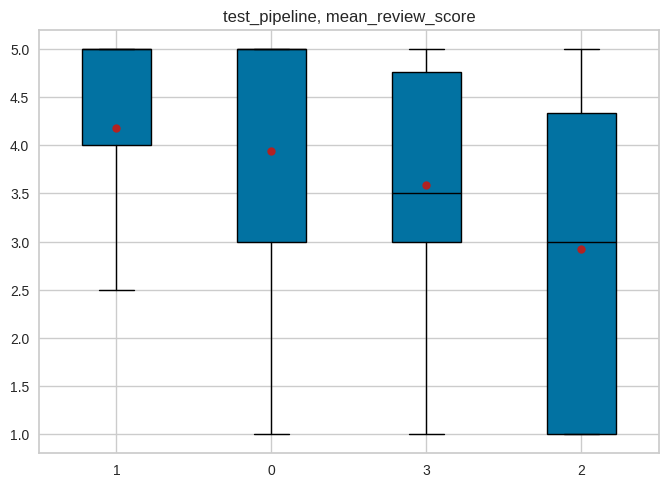

<Figure size 1300x1300 with 0 Axes>

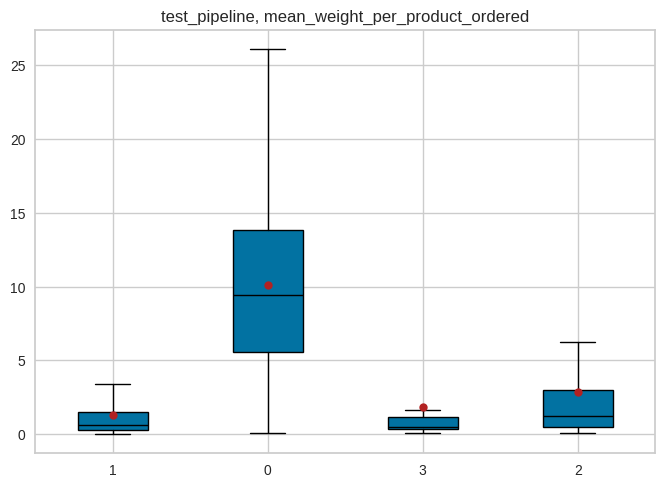

<Figure size 1300x1300 with 0 Axes>

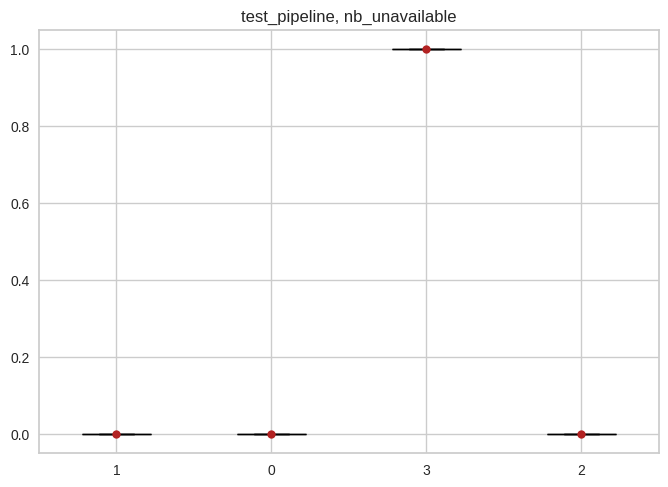

<Figure size 1300x1300 with 0 Axes>

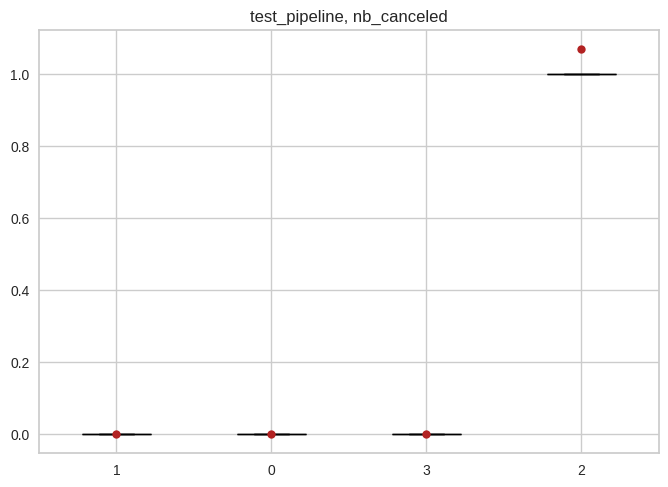

<Figure size 1300x1300 with 0 Axes>

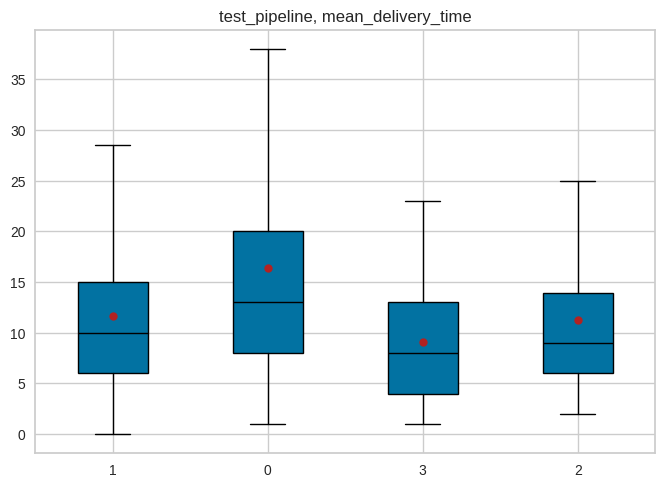

<Figure size 1300x1300 with 0 Axes>

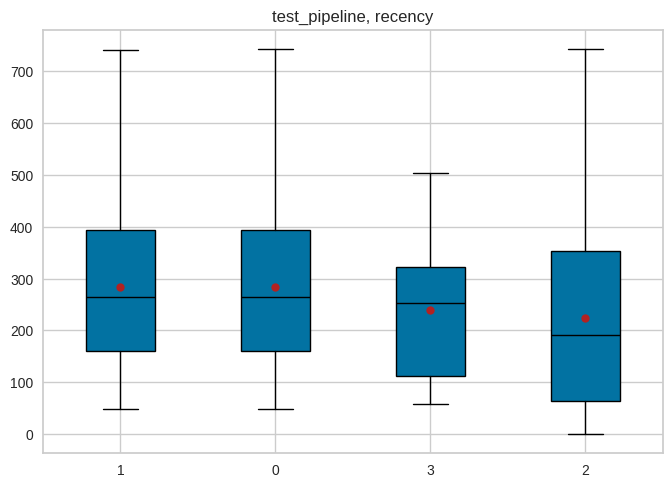

<Figure size 1300x1300 with 0 Axes>

[]


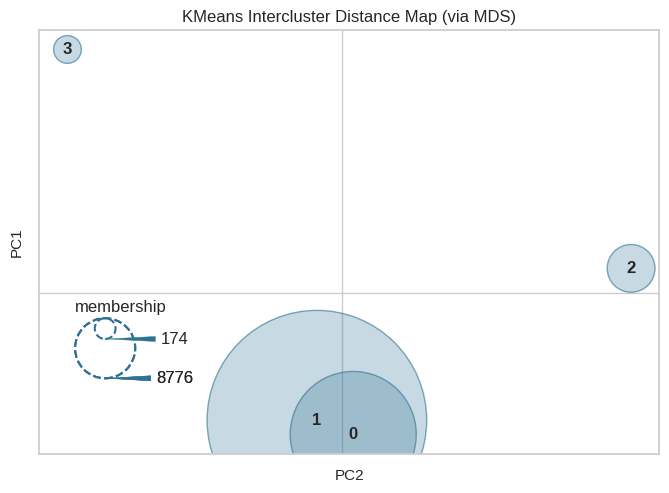

PCA Components:
 [[-0.02047541 -0.00614741  0.47436076  0.56641848  0.33846163 -0.10836385
   0.52671586 -0.00989799  0.02414515  0.22002485  0.02957115]
 [ 0.69574539  0.0091774   0.03499226  0.01178657  0.06174173  0.06802646
   0.01767887  0.63942052  0.24797956 -0.1240141  -0.14144469]]


In [183]:
analyze("test_pipeline", pipeline_kmeans_opti, param_grid_kmeans_opti, numeric_features, categorical_features, 4)

In [25]:
result_df

,model_name,fit_time (s),best_params,mean_test_score
0,kmeans_RFM,0.28,"{'clusterer': KMeans(), 'clusterer__init': 'k-...",-21713.62
1,kmeans_RFM_opti,0.18,"{'clusterer': KMeans(), 'clusterer__init': 'k-...",-38303.79


# Kmeans RFM

Unique values :
 [1 0 2 3]


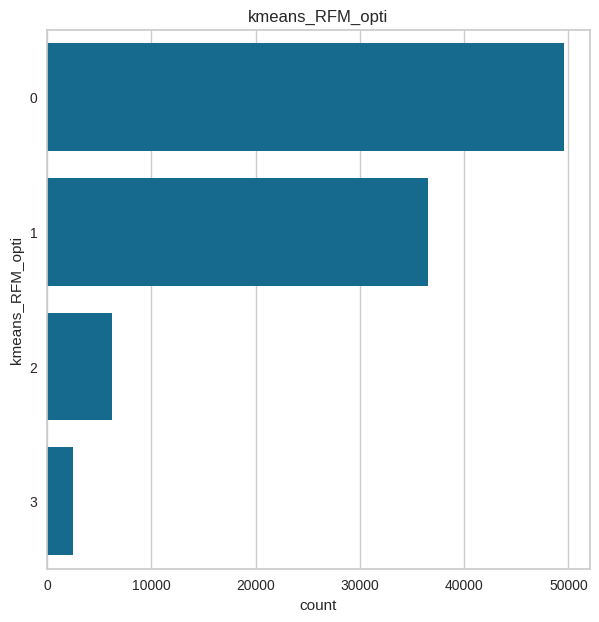

In [26]:
df["kmeans_RFM_opti"] = grid_search_kmeans_opti.predict(X_train)
uni_ana_qual(df, "kmeans_RFM_opti")

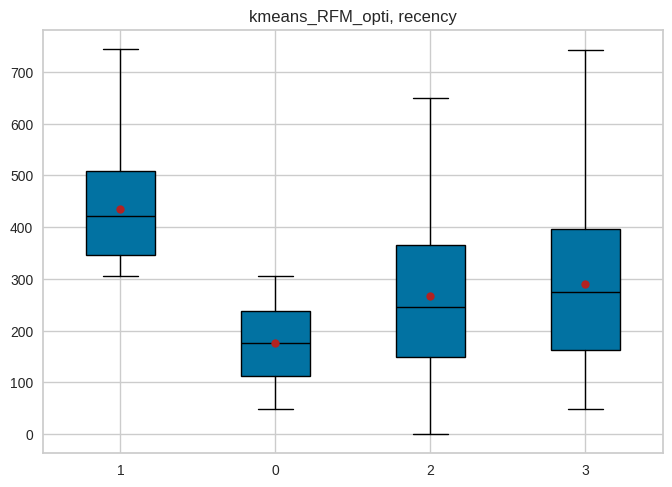

<Figure size 1300x1300 with 0 Axes>

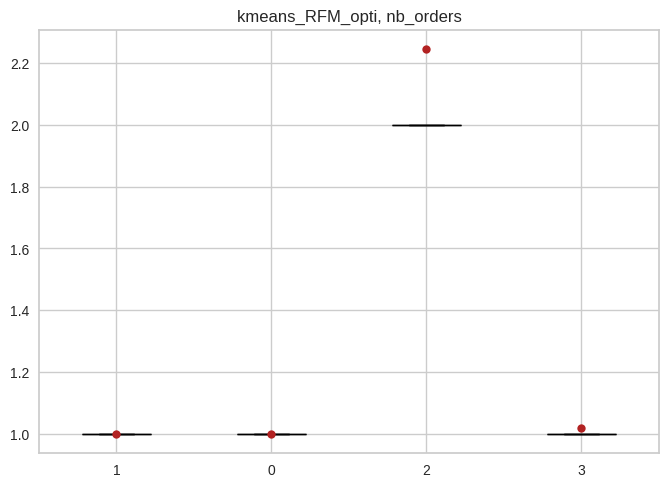

<Figure size 1300x1300 with 0 Axes>

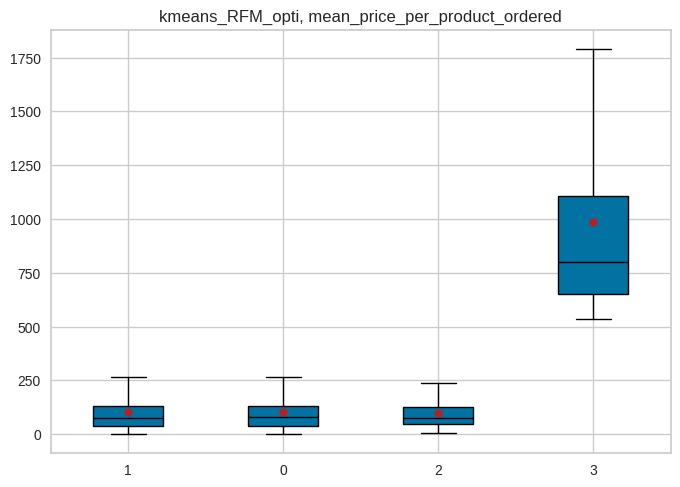

<Figure size 1300x1300 with 0 Axes>

In [27]:
anova(df, "kmeans_RFM_opti", "recency")
anova(df, "kmeans_RFM_opti", "nb_orders")
anova(df, "kmeans_RFM_opti", "mean_price_per_product_ordered")

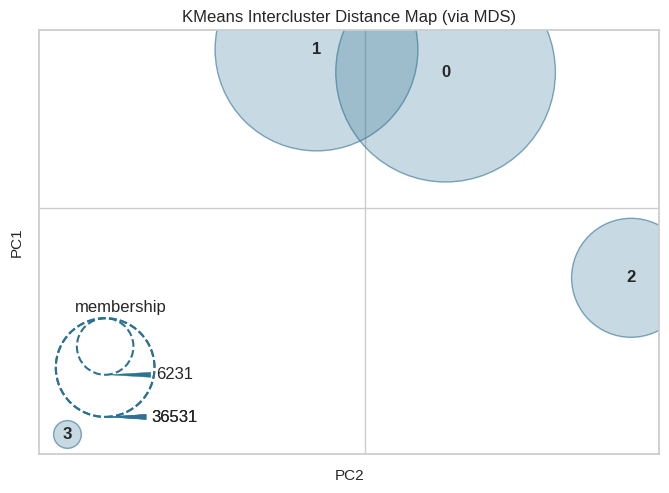

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [28]:
from yellowbrick.cluster import InterclusterDistance
from sklearn.decomposition import PCA

# Inter cluster distance map


# Instantiate the clustering model and visualizer
model = KMeans(4, random_state=42)
best_pipeline = grid_search_kmeans_opti.best_estimator_
best_kmeans = best_pipeline.named_steps['clusterer']
visualizer = InterclusterDistance(best_kmeans)

df_visu_inter = df[
            [
                "recency",
                "nb_orders",
                "mean_price_per_product_ordered",
            ]
        ]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[["recency", "nb_orders", "mean_price_per_product_ordered"]])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

visualizer.fit(
   # StandardScaler().fit_transform(    )
   X_scaled
)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [29]:
print("PCA Components:\n", pca.components_)

PCA Components:
 [[-0.62332879  0.69471325 -0.35893554]
 [-0.45920302  0.04632891  0.88712244]]


In [184]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'customer_state', 'nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered', 'most_frequent_payment_type',
       'mean_payment_installments', 'mean_review_score',
       'most_frequent_product_category', 'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency', 'test_pipeline', 'all_columns'],
      dtype='object')

# Kmeans : RFM + "mean_weight_per_product_ordered" OR "mean_review_score", k=4

In [201]:
vars = ['customer_state', 'nb_orders',
       'mean_items_per_order', 'mean_price_per_product_ordered',
       'mean_freight_value_per_product_ordered', 'most_frequent_payment_type',
       'mean_payment_installments', 'mean_review_score',
       'most_frequent_product_category', 'mean_weight_per_product_ordered',
       'nb_unavailable', 'nb_canceled', 'mean_delay', 'mean_delivery_time',
       'recency']
numeric_features = ['nb_orders',
       'mean_price_per_product_ordered',
       'recency',
       'mean_review_score'
       ]
categorical_features = []

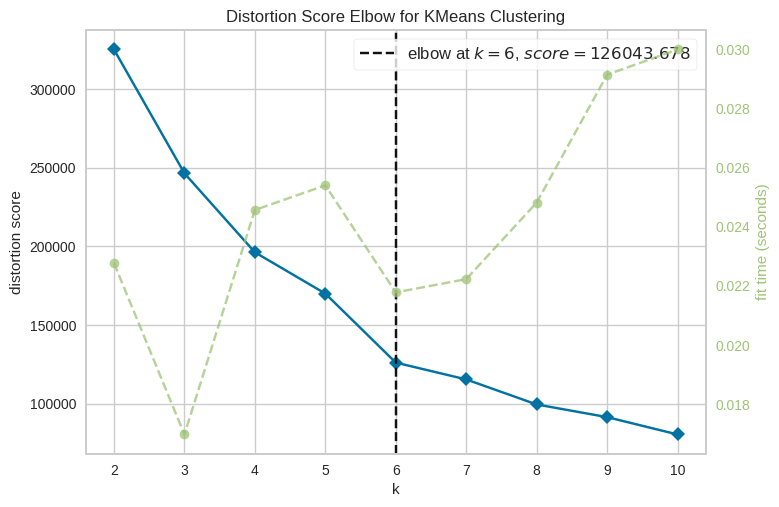

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [202]:
k= 4
kmeans_opti = KMeans()
#dbscan = DBSCAN()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardiser les variables numériques
        ('cat', OneHotEncoder(), categorical_features)  # Encoder les variables catégorielles
    ])

# Créer une pipeline avec le préprocesseur et un modèle de clustering (KMeans dans cet exemple)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', KMeans())
])
param_grid_kmeans_opti = [
    {
        'clusterer': [KMeans()],
        'clusterer__n_clusters': [k],
        'clusterer__init': ['k-means++', 'random'],
        'clusterer__n_init': [10]
    },
    # {
    #     'clusterer': [DBSCAN()],
    #     'clusterer__eps': np.arange(0.1, 1.5, 0.2),
    #     'clusterer__min_samples': np.arange(3, 10),
    # }
]

pipeline_kmeans_opti = Pipeline([
    ('preprocessor', preprocessor), 
    ('clusterer', kmeans)
])

import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Applique le preprocessor
X_processed = preprocessor.fit_transform(df[numeric_features + categorical_features])

# Convertit en matrice dense si nécessaire
if hasattr(X_processed, 'toarray'):  # Vérifie si c'est une matrice sparse
    X_processed = X_processed.toarray()

# Initialise le modèle et le visualiseur
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11))

# Fit les données au visualiseur
visualizer.fit(X_processed)
visualizer.show()  # Affiche le graphe


Unique values :
 [1 2 0 3]


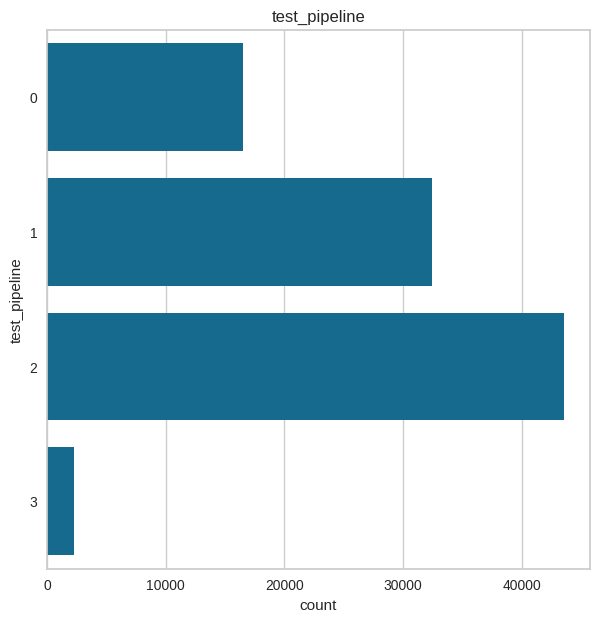

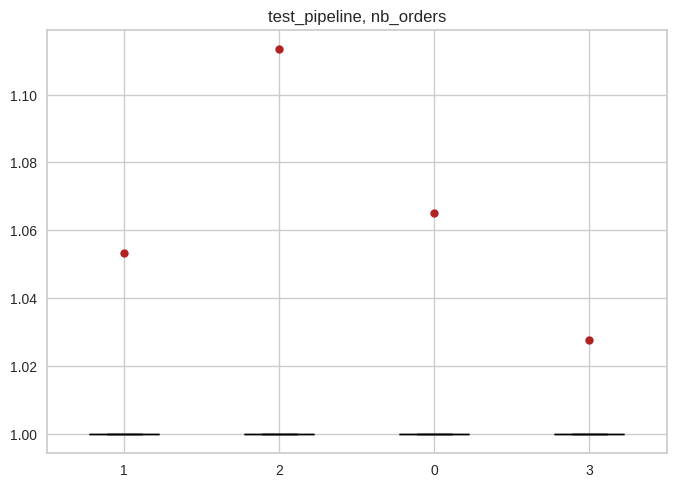

<Figure size 1300x1300 with 0 Axes>

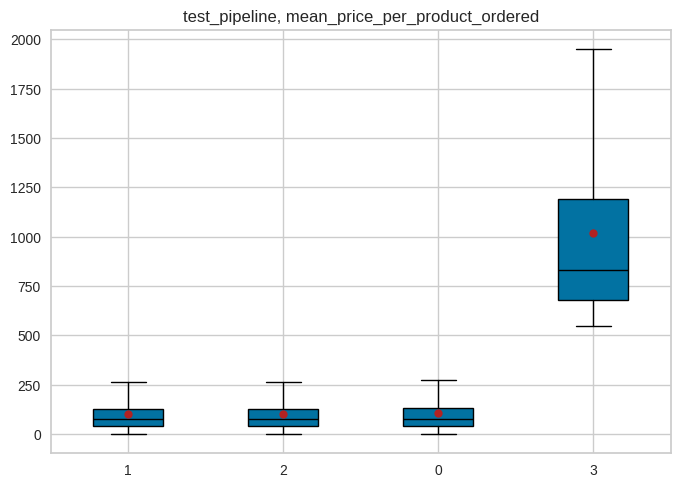

<Figure size 1300x1300 with 0 Axes>

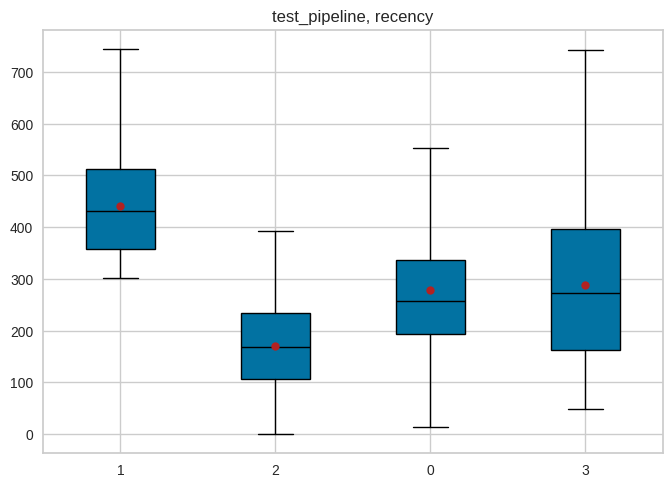

<Figure size 1300x1300 with 0 Axes>

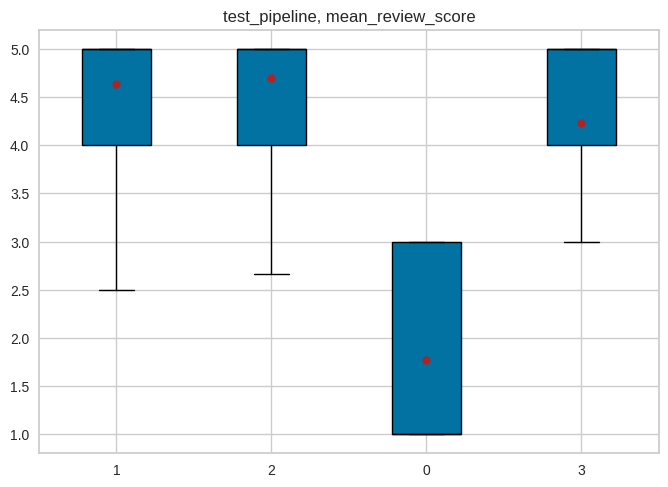

<Figure size 1300x1300 with 0 Axes>

[]


/home/omar-oc/anaconda3/envs/env_OC_P4/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


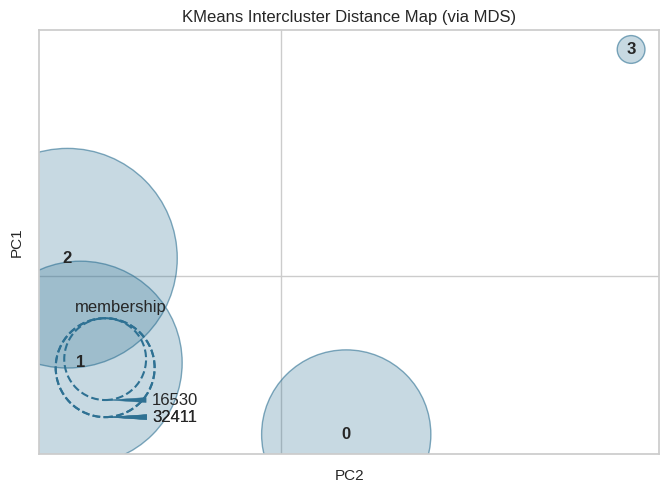

PCA Components:
 [[ 0.67053057 -0.35833304 -0.60933243  0.22516701]
 [-0.19660771 -0.51676263  0.36443916  0.74932362]]


In [203]:
analyze("test_pipeline", pipeline_kmeans_opti, param_grid_kmeans_opti, numeric_features, categorical_features, k)

# DBSCAN

In [69]:
## Finding best values of eps and min_samples
from sklearn.metrics import silhouette_score
 
eps_values=np.arange(start=0.3, stop=0.6, step=0.1)
min_samples=[4, 10, 50, 100]
 
silhouette_scores_data=pd.DataFrame()
 
X = StandardScaler().fit_transform(df[['recency','nb_orders','mean_price_per_product_ordered']].iloc[0:10000])

silhouette_scores_data = pd.DataFrame(columns=["score", "eps_trial", "min_sample_trial"])

for eps_trial in eps_values:
    for min_sample in min_samples:
        sil_score = silhouette_score(X, dbscan.fit_predict(X))
        
        silhouette_scores_data = pd.concat(
            [silhouette_scores_data, 
             pd.DataFrame(data=[[sil_score, eps_trial, min_sample]], 
                          columns=["score", "eps_trial", "min_sample_trial"])
            ], 
            ignore_index=True
        )
    

 # Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(1)


/tmp/ipykernel_101187/183004769.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  silhouette_scores_data = pd.concat(


,score,eps_trial,min_sample_trial
0,0.431229,0.3,4


In [63]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=0.3, min_samples=4)

clusters_dbscan = db.fit_predict(
    StandardScaler().fit_transform(
        df[['recency','nb_orders','mean_price_per_product_ordered']].iloc[0:10000]
    )
)

In [64]:
df_dbscan = df.iloc[0:10000]

In [65]:
df_dbscan["dbscan"] = clusters_dbscan

/tmp/ipykernel_101187/108670925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dbscan["dbscan"] = clusters_dbscan


In [66]:
def analyze_dbscan(name, numeric_features, categorical_features):
    
    uni_ana_qual(df_dbscan, name)

    for variable in numeric_features:
        if variable in numeric_features:
            anova(df_dbscan, name, variable)

    for variable in categorical_features:
        print(variable)
        plt.figure(figsize=(40, 15))
        sns.histplot(
            data=df_dbscan,
            x=variable,
            hue="test_pipeline",
            multiple="dodge",
            shrink=0.7,
            palette="Set1",
        )
        plt.xticks(rotation=75, ha="right")
        plt.show()

Unique values :
 [ 0  1 -1  2  3  4  5  6  7  9  8 10 11]


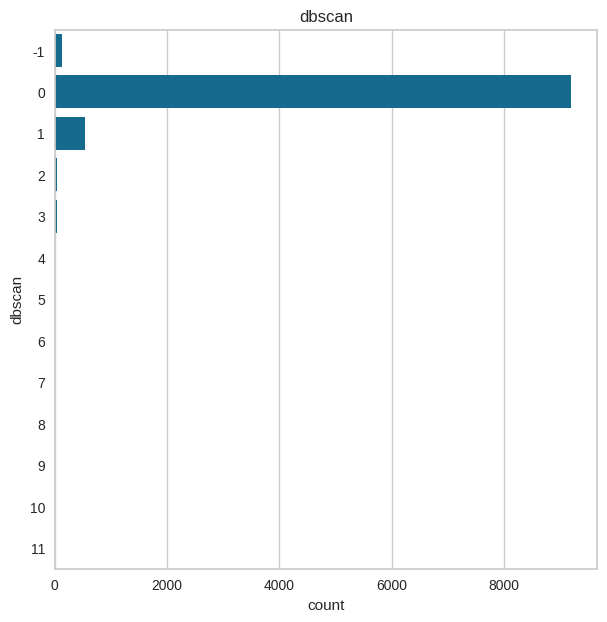

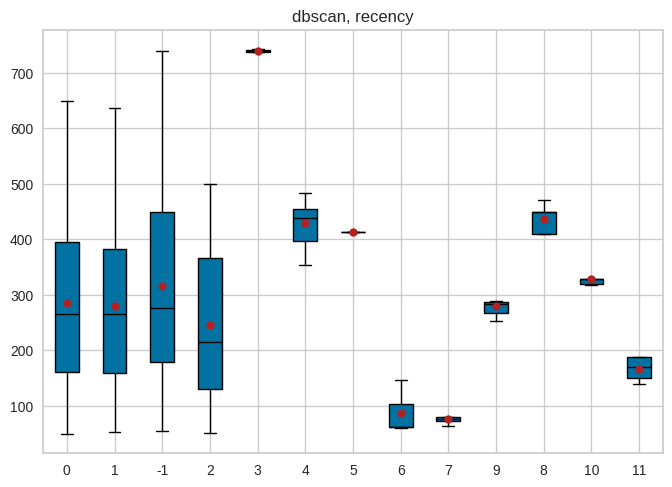

<Figure size 1300x1300 with 0 Axes>

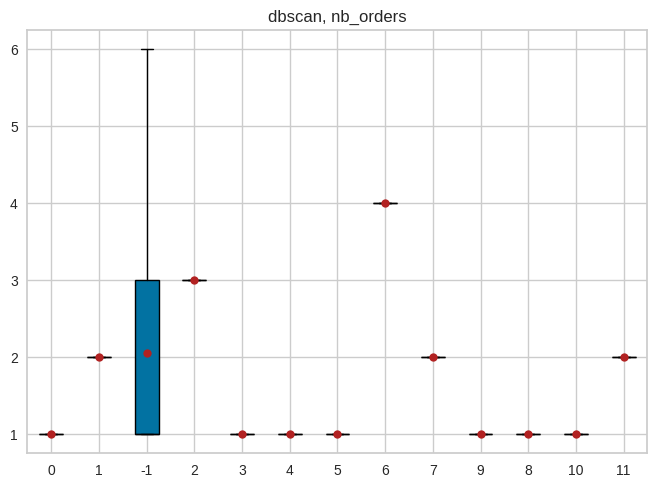

<Figure size 1300x1300 with 0 Axes>

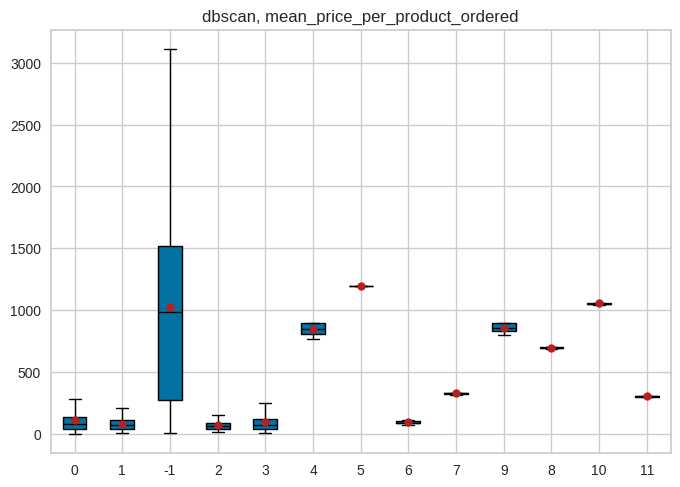

<Figure size 1300x1300 with 0 Axes>

[]


In [67]:
analyze_dbscan("dbscan",['recency','nb_orders','mean_price_per_product_ordered'], [])

# Save dataframe with cluster predictions

In [68]:
df.to_csv("results.csv")

In [32]:
result_df

,model_name,fit_time (s),best_params,mean_test_score
0,kmeans_RFM,0.41,"{'clusterer': KMeans(), 'clusterer__init': 'k-...",-21574.67
